# Download data
This code finds data on yahoo finance and downloads it into appropriate folders to run the other code. It then filters for bad data and makes folders with only some of the data in to allow robustness checks. To prevent an excessive number of calls on the database or reduce runtime, it may be desirable to only add part of the possible options to the "dir_and_files" dictionary.

In [1]:
from datetime import timedelta, datetime
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
import shutil
from pathlib import Path
from scipy.stats import linregress, pearsonr

In [2]:
# If we want to get replicable results, we should reuse the same end date, 
# though currently we want to use the latest available data
end_date = pd.datetime(year=2025, month=2, day=25)
# Only want companies that start before this date
start_date_needed = pd.datetime(year=2011, month=1, day=1)

C:\Users\rlamboll\AppData\Local\Temp\ipykernel_16324\3089573500.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  end_date = pd.datetime(year=2025, month=2, day=25)
C:\Users\rlamboll\AppData\Local\Temp\ipykernel_16324\3089573500.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  start_date_needed = pd.datetime(year=2011, month=1, day=1)


In [3]:
# Initialise the dictionary connecting names of folders to yahoo finance tickers that should go in them: 
dir_and_files = {"Assorted": ["^IRX"], "SandP": ["^SPX"]}

In [4]:
top_companies = pd.read_csv("./input/companiesmarketcap.com - Companies ranked by Market Cap - CompaniesMarketCap.com.csv")
top_companies

,Rank,Name,Symbol,marketcap,price (USD),country,Exclude,Sustainalytics value,Sustainalytics 20-30,Sustainalytics <20,Sustainalytics >30,Unnamed: 11,S&P ESG environmental,S&P ESG,Unnamed: 14,Unnamed: 15,Unnamed: 16,Rank sustainalytics,Rank S&P,Unnamed: 19
0,1,Apple,AAPL,2.870000e+12,184.225,United States,NaN,16.7,0.0,1.0,0.0,NaN,54.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Microsoft,MSFT,2.830000e+12,381.240,United States,NaN,15.4,0.0,1.0,0.0,NaN,73.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Saudi Aramco,2222.SR,2.120000e+12,8.780,Saudi Arabia,FF and too new,47.2,0.0,0.0,0.0,NaN,13.0,18.0,NaN,NaN,NaN,0.017544,0.974138,0.974138
3,4,Alphabet (Google),GOOG,1.780000e+12,143.250,United States,NaN,24.2,1.0,0.0,0.0,NaN,66.0,47.0,NaN,NaN,NaN,0.359649,0.224138,0.465517
4,5,Amazon,AMZN,1.590000e+12,153.560,United States,NaN,29.9,1.0,0.0,0.0,NaN,34.0,22.0,NaN,NaN,NaN,0.140351,0.844828,0.965517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7968,7969,Ozon,OZON.ME,0.000000e+00,32.020,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7969,7970,Emirates NBD Bank PJSC,EMIRATESNBD.AE,0.000000e+00,0.000,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7970,7971,Emaar Properties,EMAAR.AE,0.000000e+00,0.000,United Arab Emirates,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7971,7972,Energy Harbor,ENGH,0.000000e+00,0.000,United States,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Filter out scenarios which are invalid for some reason (usually bad start dates or not listed on normal stock exchanges)
top_companies = top_companies[top_companies["Exclude"]!=top_companies["Exclude"]]
# Some of these companies will fail upon load later, so we use 105 to get top 100
top_companies = top_companies[:105]
top_companies

,Rank,Name,Symbol,marketcap,price (USD),country,Exclude,Sustainalytics value,Sustainalytics 20-30,Sustainalytics <20,Sustainalytics >30,Unnamed: 11,S&P ESG environmental,S&P ESG,Unnamed: 14,Unnamed: 15,Unnamed: 16,Rank sustainalytics,Rank S&P,Unnamed: 19
0,1,Apple,AAPL,2.870000e+12,184.225,United States,NaN,16.7,0.0,1.0,0.0,NaN,54.0,44.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Microsoft,MSFT,2.830000e+12,381.240,United States,NaN,15.4,0.0,1.0,0.0,NaN,73.0,56.0,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Alphabet (Google),GOOG,1.780000e+12,143.250,United States,NaN,24.2,1.0,0.0,0.0,NaN,66.0,47.0,NaN,NaN,NaN,0.359649,0.224138,0.465517
4,5,Amazon,AMZN,1.590000e+12,153.560,United States,NaN,29.9,1.0,0.0,0.0,NaN,34.0,22.0,NaN,NaN,NaN,0.140351,0.844828,0.965517
5,6,NVIDIA,NVDA,1.340000e+12,541.350,United States,NaN,13.5,0.0,1.0,0.0,NaN,57.0,61.0,NaN,NaN,NaN,0.850877,0.413793,0.172414
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
114,115,Unilever,UL,1.220000e+11,48.975,United Kingdom,NaN,22.2,0.0,1.0,0.0,NaN,63.0,58.0,NaN,NaN,NaN,NaN,NaN,NaN
115,116,Charles Schwab,SCHW,1.200000e+11,66.105,United States,NaN,23.4,0.0,1.0,0.0,NaN,19.0,34.0,NaN,NaN,NaN,NaN,NaN,NaN
116,117,AT&T,T,1.200000e+11,16.785,United States,NaN,22.1,0.0,1.0,0.0,NaN,61.0,59.0,NaN,NaN,NaN,NaN,NaN,NaN
117,118,Sony,SONY,1.180000e+11,95.750,Japan,NaN,15.6,0.0,1.0,0.0,NaN,68.0,55.0,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# determine the correspondance between S&P and Sustainalytics ratings
Cola = "Sustainalytics value"
Colb = "S&P ESG environmental"
Colc = "S&P ESG"
# Fit linear regression
slope, intercept, _, _, _ = linregress(top_companies.dropna(subset=[Cola, Colb])[Cola], top_companies.dropna(subset=[Cola, Colb])[Colb])

# Compute Colb when Cola = 20 and 30
colb_10 = slope * 10 + intercept
colb_20 = slope * 20 + intercept
colb_30 = slope * 30 + intercept

In [7]:
slope, intercept, _, _, _ = linregress(top_companies.dropna(subset=[Cola, Colc])[Cola], top_companies.dropna(subset=[Cola, Colc])[Colc])
# Compute Colc when Cola = 20 and 30
colc_20 = slope * 20 + intercept
colc_30 = slope * 30 + intercept
colc_10 = slope * 10 + intercept

C:\Users\rlamboll\AppData\Local\Temp\ipykernel_16324\4032032886.py:7: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x000001DB961A54F0> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Trend", "Green Sustainalytics limit", "Green S&P limit"])


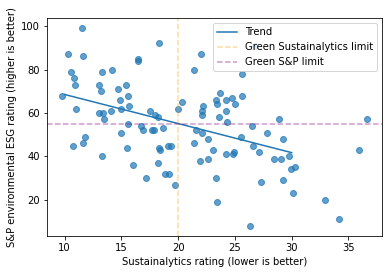

In [8]:
plt.scatter(top_companies[Cola],top_companies[Colb], alpha=0.7)
plt.plot([10, 30], [colb_10, colb_30])
plt.axvline(x=20, color="orange", alpha=0.4, linestyle="--")
plt.axhline(y=colb_20, color="purple", alpha=0.4, linestyle="--")
plt.xlabel("Sustainalytics rating (lower is better)")
plt.ylabel("S&P environmental ESG rating (higher is better)")
plt.legend(["_", "Trend", "Green Sustainalytics limit", "Green S&P limit"])

In [9]:
pearsonr(top_companies.dropna(subset=[Cola, Colb])[Cola],top_companies.dropna(subset=[Cola, Colb])[Colb])

(-0.4620148446182948, 1.1534064326591584e-06)

In [10]:
pearsonr(top_companies.dropna(subset=[Cola, Colc])[Cola],top_companies.dropna(subset=[Cola, Colc])[Colc])

(-0.4939944110202923, 1.5234289487486572e-07)

In [11]:
len(top_companies.dropna(subset=[Cola, Colc]))

101

In [12]:
sandpesgEnv = (top_companies[top_companies[Colb] > colb_20])
assert len(sandpesgEnv) > 34
len(sandpesgEnv)

49

C:\Users\rlamboll\AppData\Local\Temp\ipykernel_19552\817356175.py:7: UserWarning: The handle <matplotlib.collections.PathCollection object at 0x0000022591AEEA90> has a label of '_' which cannot be automatically added to the legend.
  plt.legend(["_", "Trend", "Green Sustainalytics limit", "Good S&P limit"])


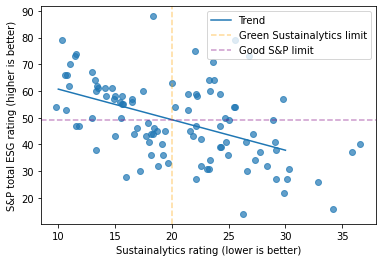

In [13]:
plt.scatter(top_companies[Cola],top_companies[Colc], alpha=0.7)
plt.plot([10, 30], [colc_10, colc_30])
plt.axvline(x=20, color="orange", alpha=0.4, linestyle="--")
plt.axhline(y=colc_20, color="purple", alpha=0.4, linestyle="--")
plt.xlabel("Sustainalytics rating (lower is better)")
plt.ylabel("S&P total ESG rating (higher is better)")
plt.legend(["_", "Trend", "Green Sustainalytics limit", "Good S&P limit"])

In [14]:
sandpesg = (top_companies[top_companies[Colc] > colc_20])
assert len(sandpesg) > 34
len(sandpesg)

47

In [15]:
sum(top_companies[Cola] < 20)

50

In [16]:
colb_20

55.1241042593556

In [17]:
colc_20

49.27848539637491

In [18]:
dir_and_files["SandPESG_32"] = sandpesgEnv["Symbol"].iloc[:32].values

In [19]:
dir_and_files["SandP_32"] = sandpesg["Symbol"].iloc[:32].values

In [20]:
dir_and_files["all_companies"] = top_companies["Symbol"].values

In [21]:
# Two of these files won't be available from the start too
dir_and_files["constsust_34"] = top_companies.loc[top_companies["Sustainalytics 20-30"]==1, "Symbol"][:35].values

In [22]:
# Two of these files won't be available from the startoo
dir_and_files["greencred_34"] = top_companies.loc[top_companies["Sustainalytics <20"]==1, "Symbol"][:35].values

In [23]:
top_ffs = pd.read_csv("./input/companiesmarketcap.com - Largest oil and gas companies by market cap.csv")
top_ffs = top_ffs[top_ffs["Exclude"]!=top_ffs["Exclude"]]
# Several of these companies start too late, so we use more to get top 100
top_ffs = top_ffs[:131]
dir_and_files["fossil_100"] = top_ffs["Symbol"].values

In [24]:
top_rens = pd.read_csv("./input/companiesmarketcap.com - Largest renewable energy companies by market cap.csv")
top_rens = top_rens[top_rens["Exclude"]!=top_rens["Exclude"]]
dir_and_files["renewable_all"] = top_rens["Symbol"].values

In [25]:
len(dir_and_files["renewable_all"])

64

In [26]:
top_ffs

,Rank,Name,Symbol,marketcap,price (USD),country,Exclude
1,2,Exxon Mobil,XOM,4.030000e+11,100.90,United States,NaN
2,3,Chevron,CVX,2.820000e+11,149.35,United States,NaN
3,4,Shell,SHEL,2.100000e+11,64.08,United Kingdom,NaN
4,5,PetroChina,601857.SS,1.660000e+11,0.95,China,NaN
5,6,TotalEnergies,TTE,1.580000e+11,66.93,France,NaN
...,...,...,...,...,...,...,...
132,133,DT Midstream,DTM,5.142372e+09,53.03,United States,NaN
133,134,Romgaz,RZ8G.F,5.123524e+09,10.99,Romania,NaN
134,135,China Gas,0384.HK,5.043708e+09,0.93,China,NaN
135,136,Transocean,RIG,4.943179e+09,6.11,Switzerland,NaN


In [27]:
for dir, companies in dir_and_files.items():
    directory = "./input/" + dir + "/"
    os.makedirs(directory, exist_ok=True)
    for company in companies:
        try:
            companydata = yf.Ticker(company)
            # get historical market data
            hist = companydata.history(start="1990-01-01", end=end_date)
            if hist.index[0].tz_localize(None) < start_date_needed:
                hist.index = hist.index.tz_localize(None).strftime('%Y-%m-%d')
                if any(hist.Close < 0):
                    negend = np.max(hist[hist.Close < 0].index)
                    if datetime.strptime(negend, "%Y-%m-%d") < start_date_needed:
                        print(
                            f"Negative values in {company} before {np.max(hist[hist.Close < 0].index)}, removing data"
                        )
                        hist = hist[hist.index > negend]
                    elif company == "^IRX":
                        print(f"Negative values in {company} before {np.max(hist[hist.Close < 0].index)}, it's fine for ^IRX")
                    else:
                        print(
                            f"Negative values in {company} before {np.max(hist[hist.Close < 0].index)}, didn't save data"
                        )
                        continue
                hist.to_csv(directory + company + ".csv")
            else:
                print(f"Company {company} data not available until {hist.index[0]}")
        except:
            print(f"Failed to get {company} data")

Negative values in ^IRX before 2020-03-27, it's fine for ^IRX


$IHC.AE: possibly delisted; no timezone found


Failed to get IHC.AE data
Company BABA data not available until 2014-09-19 00:00:00-04:00
Company NOW data not available until 2012-06-29 00:00:00-04:00
Company PRX.AS data not available until 2019-09-11 00:00:00+02:00
Company BABA data not available until 2014-09-19 00:00:00-04:00
Company NOW data not available until 2012-06-29 00:00:00-04:00


$PXD: possibly delisted; no price data found  (1d 1990-01-01 -> 2025-02-25 00:00:00) (Yahoo error = "No data found, symbol may be delisted")


Failed to get PXD data
Company NVTK.ME data not available until 2011-11-21 00:00:00+04:00
Company KMI data not available until 2011-02-11 00:00:00-05:00
Company MPLX data not available until 2012-10-26 00:00:00-04:00
Company FANG data not available until 2012-10-12 00:00:00-04:00


$ADNOCDRILL.AE: possibly delisted; no timezone found


Failed to get ADNOCDRILL.AE data
Company TATN.ME data not available until 2011-11-21 00:00:00+04:00


$MRO: possibly delisted; no price data found  (1d 1990-01-01 -> 2025-02-25 00:00:00) (Yahoo error = "No data found, symbol may be delisted")


Failed to get MRO data


$MMP: possibly delisted; no timezone found


Failed to get MMP data
Company ATGL.NS data not available until 2018-11-05 00:00:00+05:30


$ADNOCDIST.AE: possibly delisted; no timezone found


Failed to get ADNOCDIST.AE data
Company WES data not available until 2012-12-10 00:00:00-05:00
Negative values in TUPRS.IS before 2004-04-19, removing data


$CHK: possibly delisted; no price data found  (1d 1990-01-01 -> 2025-02-25 00:00:00) (Yahoo error = "No data found, symbol may be delisted")


Failed to get CHK data
Company PR data not available until 2016-04-15 00:00:00-04:00
Company NFE data not available until 2019-01-31 00:00:00-05:00
Company VAR.OL data not available until 2022-02-16 00:00:00+01:00
Company HESM data not available until 2017-04-05 00:00:00-04:00


$SWN: possibly delisted; no price data found  (1d 1990-01-01 -> 2025-02-25 00:00:00) (Yahoo error = "No data found, symbol may be delisted")


Failed to get SWN data
Company OR.BK data not available until 2021-02-11 00:00:00+07:00
Company MTDR data not available until 2012-02-02 00:00:00-05:00
Company AR data not available until 2013-10-10 00:00:00-04:00
Company CIVI data not available until 2011-12-15 00:00:00-05:00
Company WFRD data not available until 2021-01-04 00:00:00-05:00
Company NE data not available until 2021-06-09 00:00:00-04:00
Company AM data not available until 2017-05-04 00:00:00-04:00
Company MPHC.QA data not available until 2014-02-25 00:00:00+03:00
Company VNOM data not available until 2014-06-18 00:00:00-04:00
Company PBF data not available until 2012-12-13 00:00:00-05:00
Company DTM data not available until 2021-07-01 00:00:00-04:00
Company RZ8G.F data not available until 2013-11-18 00:00:00+01:00
Company MNTK data not available until 2021-01-22 00:00:00-05:00
Company SCATC.OL data not available until 2014-10-02 00:00:00+02:00
Company SWSOLAR.NS data not available until 2019-08-20 00:00:00+05:30
Company A

$CE2.F: possibly delisted; no timezone found


Failed to get CE2.F data


$NETI: possibly delisted; no timezone found


Failed to get NETI data
Company NRGV data not available until 2021-03-29 00:00:00-04:00
Company MAXN data not available until 2020-08-26 00:00:00-04:00
Company GEVO data not available until 2011-02-09 00:00:00-05:00


$GPP: possibly delisted; no timezone found


Failed to get GPP data
Company FF data not available until 2011-03-23 00:00:00-04:00
Company GWH data not available until 2021-01-04 00:00:00-05:00
Company LCFS.TO data not available until 2021-08-13 00:00:00-04:00


$MCPHY.PA: possibly delisted; no price data found  (1d 1990-01-01 -> 2025-02-25 00:00:00) (Yahoo error = "No data found, symbol may be delisted")


Failed to get MCPHY.PA data
Company EVA data not available until 2015-04-29 00:00:00-04:00
Company SPRU data not available until 2019-09-03 00:00:00-04:00
Company AZREF data not available until 2016-10-12 00:00:00-04:00


$XBC.TO: possibly delisted; no timezone found


Failed to get XBC.TO data
Company CETY data not available until 2023-01-19 00:00:00-05:00
Company CMC.V data not available until 2011-08-10 00:00:00-04:00
Company SPI data not available until 2017-09-19 00:00:00-04:00
Company VGAS data not available until 2021-10-04 00:00:00-04:00


$SUNW: possibly delisted; no timezone found


Failed to get SUNW data
Company HMGS.TA data not available until 2021-02-02 00:00:00+02:00
Company ADN data not available until 2019-01-23 00:00:00-05:00
Company TURB data not available until 2023-09-22 00:00:00-04:00
Company HLGN data not available until 2021-05-07 00:00:00-04:00


$CGRN: possibly delisted; no timezone found


Failed to get CGRN data
Company VVPR data not available until 2015-05-27 00:00:00-04:00
Company ASTI data not available until 2022-08-24 00:00:00-04:00


# Check for bad data

In [28]:
# Define some useful functions
def running_mean(x, N):
    return (x["CumNoVol"][N:].values - x["CumNoVol"][:-N].values)/N

def count_true_chains(column):
    """
    Counts how many preceding rows are 'True' in an unbroken chain for each row in a column.

    Parameters:
    column (pd.Series): A pandas Series (column) containing True/False values.

    Returns:
    pd.Series: A Series with the count of preceding 'True' values for each row in an unbroken chain.
    """
    # Initialize a list to store the chain counts
    chain_count = []
    current_chain = 0  # Keeps track of the current chain of True values

    for value in column:
        if value:  # If the current value is True, increment the chain count
            current_chain += 1
        else:  # If the current value is False, reset the chain count
            current_chain = 0
        chain_count.append(current_chain)

    return pd.Series(chain_count)

def find_latest_row_with_chain_above(df, chain_column, chain_threshold):
    """
    Finds the row with the latest date where 'NoVolNoChangeChain' is above the given threshold.
    """
    filtered_df = df[df[chain_column] > chain_threshold]

    if filtered_df.empty:
        return None  # Return None if no rows match the condition

    # Find the row with the latest date
    latest_row = filtered_df.loc[filtered_df["Date"].idxmax()]

    return latest_row["Date"]

./input/all_companies\005930.KS.csv
./input/all_companies\600519.SS.csv
./input/all_companies\AAPL.csv
./input/all_companies\ABT.csv
./input/all_companies\ADBE.csv
./input/all_companies\AMAT.csv
./input/all_companies\AMD.csv
./input/all_companies\AMGN.csv
./input/all_companies\AMZN.csv
./input/all_companies\ASML.csv
./input/all_companies\AVGO.csv
./input/all_companies\AXP.csv
./input/all_companies\AZN.csv
./input/all_companies\BA.csv
./input/all_companies\BAC.csv
./input/all_companies\BHP.csv
./input/all_companies\BKNG.csv
./input/all_companies\BRK-B.csv
./input/all_companies\CAT.csv
./input/all_companies\CBA.AX.csv


<Figure size 720x360 with 0 Axes>

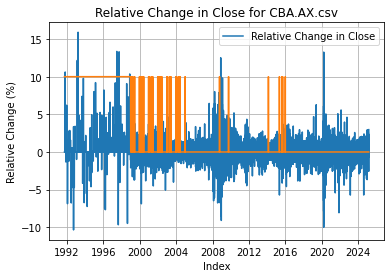

Total number of 0s in "Volume" for CBA.AX.csv: 1953 in field ./input/all_companies.
./input/all_companies\CDI.PA.csv
./input/all_companies\CMCSA.csv
./input/all_companies\COST.csv
./input/all_companies\CRM.csv
./input/all_companies\CSCO.csv
./input/all_companies\DHR.csv
./input/all_companies\DIS.csv
./input/all_companies\GOOG.csv
./input/all_companies\HD.csv
./input/all_companies\HDB.csv
./input/all_companies\HON.csv
./input/all_companies\IBM.csv
./input/all_companies\IDEXY.csv
./input/all_companies\INTC.csv
./input/all_companies\INTU.csv
./input/all_companies\ISRG.csv
./input/all_companies\JNJ.csv
./input/all_companies\JPM.csv
./input/all_companies\KO.csv
./input/all_companies\LIN.csv
./input/all_companies\LLY.csv
./input/all_companies\LOW.csv
./input/all_companies\MA.csv
./input/all_companies\MC.PA.csv
./input/all_companies\MCD.csv
./input/all_companies\MRK.csv
./input/all_companies\MS.csv
./input/all_companies\MSFT.csv
./input/all_companies\NEE.csv
./input/all_companies\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

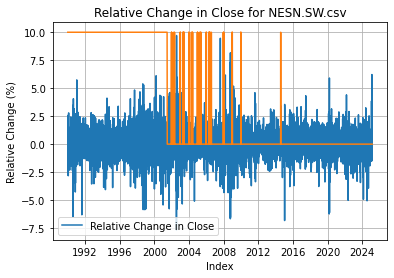

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/all_companies.
./input/all_companies\NFLX.csv
./input/all_companies\NKE.csv
./input/all_companies\NVDA.csv
./input/all_companies\NVO.csv
./input/all_companies\NVS.csv
./input/all_companies\OR.PA.csv
./input/all_companies\ORCL.csv
./input/all_companies\PEP.csv
./input/all_companies\PFE.csv
./input/all_companies\PG.csv
./input/all_companies\QCOM.csv
./input/all_companies\RMS.PA.csv
./input/all_companies\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

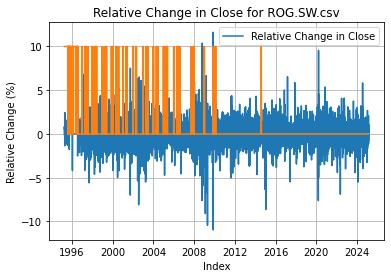

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/all_companies.
./input/all_companies\RTX.csv
./input/all_companies\RY.csv
./input/all_companies\SAP.csv
./input/all_companies\SCHW.csv
./input/all_companies\SONY.csv
./input/all_companies\SPGI.csv
./input/all_companies\T.csv
./input/all_companies\TCS.NS.csv


<Figure size 720x360 with 0 Axes>

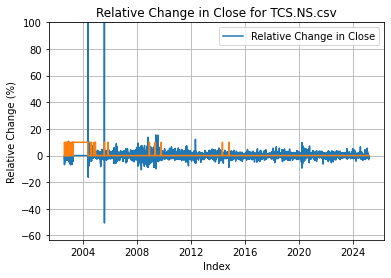

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/all_companies.
./input/all_companies\TM.csv
./input/all_companies\TMO.csv
./input/all_companies\TMUS.csv
./input/all_companies\TSM.csv
./input/all_companies\TTE.csv
./input/all_companies\TXN.csv
./input/all_companies\UL.csv
./input/all_companies\UNH.csv
./input/all_companies\UNP.csv
./input/all_companies\V.csv
./input/all_companies\VZ.csv
./input/all_companies\WFC.csv
./input/all_companies\WMT.csv


<Figure size 720x360 with 0 Axes>

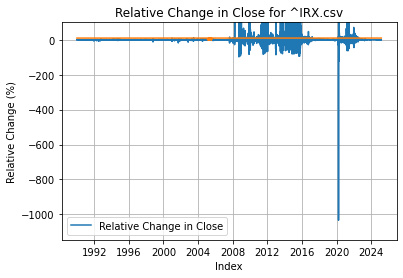

Total number of 0s in "Volume" for ^IRX.csv: 8776 in field ./input/Assorted.
./input/constsust_34\ABT.csv
./input/constsust_34\AMGN.csv
./input/constsust_34\AMZN.csv
./input/constsust_34\AZN.csv
./input/constsust_34\BAC.csv
./input/constsust_34\BHP.csv
./input/constsust_34\BRK-B.csv
./input/constsust_34\CAT.csv
./input/constsust_34\CMCSA.csv
./input/constsust_34\COST.csv
./input/constsust_34\GOOG.csv
./input/constsust_34\HDB.csv
./input/constsust_34\JNJ.csv
./input/constsust_34\JPM.csv
./input/constsust_34\LLY.csv
./input/constsust_34\MCD.csv
./input/constsust_34\MRK.csv
./input/constsust_34\MS.csv
./input/constsust_34\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

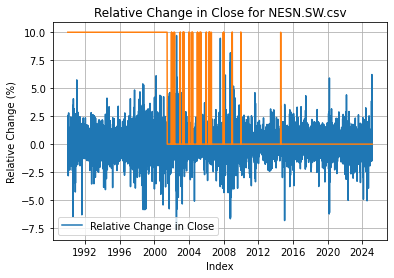

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/constsust_34.
./input/constsust_34\NVO.csv
./input/constsust_34\OR.PA.csv
./input/constsust_34\PEP.csv
./input/constsust_34\PG.csv
./input/constsust_34\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

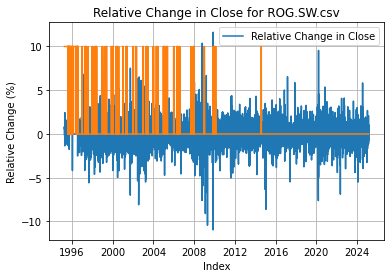

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/constsust_34.
./input/constsust_34\RY.csv
./input/constsust_34\TM.csv
./input/constsust_34\TMUS.csv
./input/constsust_34\TTE.csv
./input/constsust_34\TXN.csv
./input/constsust_34\WMT.csv
./input/fossil_100\0003.HK.csv
./input/fossil_100\010950.KS.csv
./input/fossil_100\0883.HK.csv
./input/fossil_100\096775.KS.csv
./input/fossil_100\1193.HK.csv
./input/fossil_100\1605.T.csv
./input/fossil_100\5019.T.csv
./input/fossil_100\600028.SS.csv
./input/fossil_100\6505.TW.csv
./input/fossil_100\9531.T.csv
./input/fossil_100\AKRBP.OL.csv
./input/fossil_100\ALD.AX.csv


<Figure size 720x360 with 0 Axes>

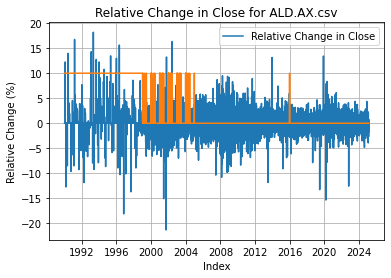

Total number of 0s in "Volume" for ALD.AX.csv: 2396 in field ./input/fossil_100.
./input/fossil_100\APA.csv
./input/fossil_100\BP.csv
./input/fossil_100\BRPT.JK.csv


<Figure size 720x360 with 0 Axes>

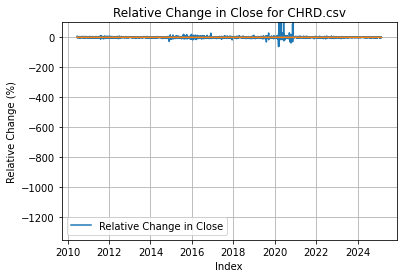

Total number of 0s in "Volume" for CHRD.csv: 0 in field ./input/fossil_100.
./input/fossil_100\CNA.L.csv
./input/fossil_100\CNQ.csv
./input/fossil_100\COP.csv
./input/fossil_100\CTRA.csv
./input/fossil_100\CVX.csv
./input/fossil_100\DINO.csv
./input/fossil_100\DUK.csv
./input/fossil_100\DVN.csv
./input/fossil_100\E.csv
./input/fossil_100\ENB.csv


<Figure size 720x360 with 0 Axes>

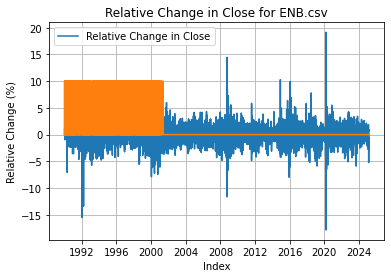

Total number of 0s in "Volume" for ENB.csv: 1237 in field ./input/fossil_100.
./input/fossil_100\ENLC.csv
./input/fossil_100\EOG.csv
./input/fossil_100\EPD.csv
./input/fossil_100\EQT.csv
./input/fossil_100\ET.csv
./input/fossil_100\FPE.F.csv


<Figure size 720x360 with 0 Axes>

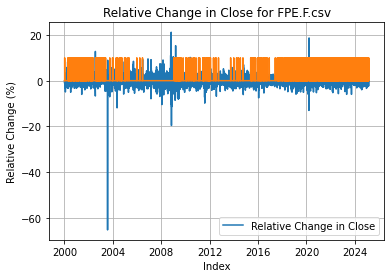

Total number of 0s in "Volume" for FPE.F.csv: 938 in field ./input/fossil_100.
./input/fossil_100\FTI.csv
./input/fossil_100\GAIL.NS.csv


<Figure size 720x360 with 0 Axes>

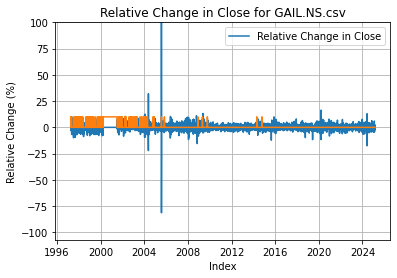

Total number of 0s in "Volume" for GAIL.NS.csv: 421 in field ./input/fossil_100.
./input/fossil_100\GZ5.F.csv


<Figure size 720x360 with 0 Axes>

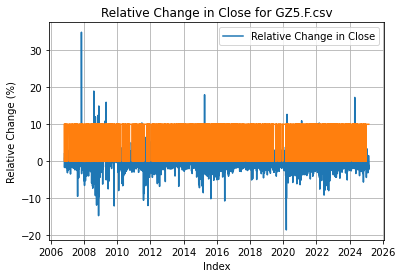

Total number of 0s in "Volume" for GZ5.F.csv: 3692 in field ./input/fossil_100.
./input/fossil_100\HAL.csv
./input/fossil_100\HES.csv
./input/fossil_100\HINDPETRO.NS.csv


<Figure size 720x360 with 0 Axes>

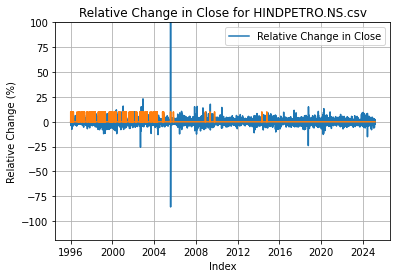

Total number of 0s in "Volume" for HINDPETRO.NS.csv: 120 in field ./input/fossil_100.
./input/fossil_100\IMO.csv
./input/fossil_100\IOC.NS.csv


<Figure size 720x360 with 0 Axes>

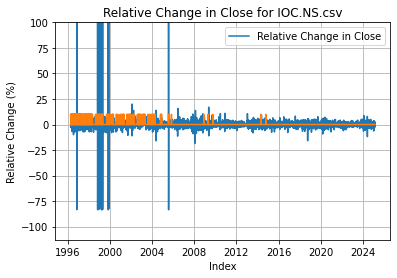

Total number of 0s in "Volume" for IOC.NS.csv: 293 in field ./input/fossil_100.
./input/fossil_100\KEY.TO.csv
./input/fossil_100\MOL.BD.csv
./input/fossil_100\NESTE.HE.csv
./input/fossil_100\NOV.csv
./input/fossil_100\OKE.csv
./input/fossil_100\OMV.F.csv


<Figure size 720x360 with 0 Axes>

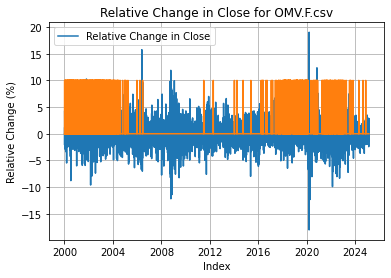

Total number of 0s in "Volume" for OMV.F.csv: 732 in field ./input/fossil_100.
./input/fossil_100\ONGC.NS.csv
./input/fossil_100\OVV.csv


<Figure size 720x360 with 0 Axes>

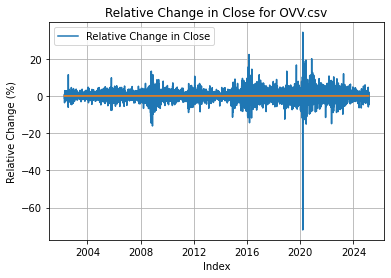

Total number of 0s in "Volume" for OVV.csv: 0 in field ./input/fossil_100.
./input/fossil_100\OXY.csv
./input/fossil_100\PAA.csv
./input/fossil_100\PBR.csv
./input/fossil_100\PKI.TO.csv


<Figure size 720x360 with 0 Axes>

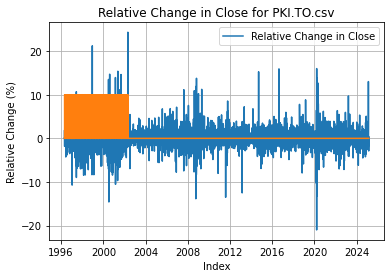

Total number of 0s in "Volume" for PKI.TO.csv: 498 in field ./input/fossil_100.
./input/fossil_100\PRIO3.SA.csv
./input/fossil_100\PTT-R.BK.csv


<Figure size 720x360 with 0 Axes>

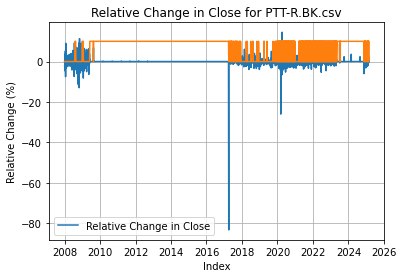

Total number of 0s in "Volume" for PTT-R.BK.csv: 1574 in field ./input/fossil_100.
./input/fossil_100\PTTEP.BK.csv


<Figure size 720x360 with 0 Axes>

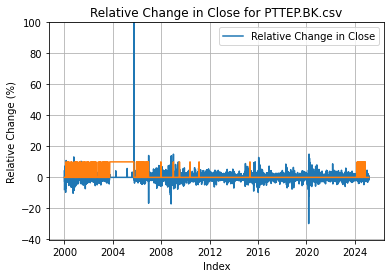

Total number of 0s in "Volume" for PTTEP.BK.csv: 649 in field ./input/fossil_100.
./input/fossil_100\RIG.csv
./input/fossil_100\RRC.csv


<Figure size 720x360 with 0 Axes>

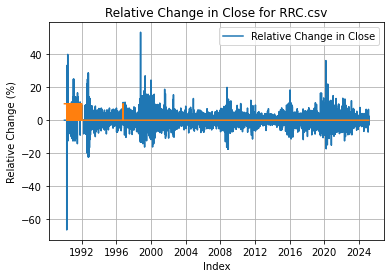

Total number of 0s in "Volume" for RRC.csv: 96 in field ./input/fossil_100.
./input/fossil_100\SHEL.csv
./input/fossil_100\SLB.csv
./input/fossil_100\SO.csv
./input/fossil_100\SRE.csv


<Figure size 720x360 with 0 Axes>

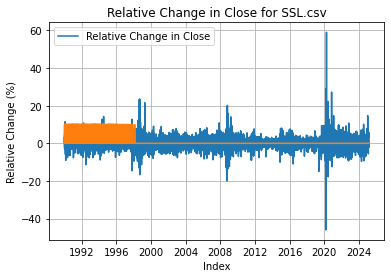

Total number of 0s in "Volume" for SSL.csv: 721 in field ./input/fossil_100.
./input/fossil_100\STO.AX.csv


<Figure size 720x360 with 0 Axes>

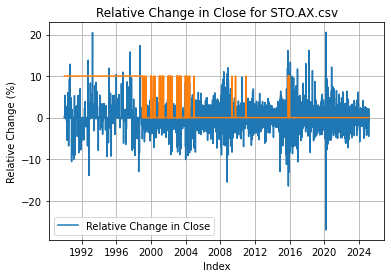

Total number of 0s in "Volume" for STO.AX.csv: 2404 in field ./input/fossil_100.
./input/fossil_100\SU.csv


<Figure size 720x360 with 0 Axes>

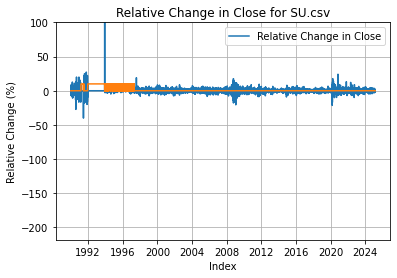

Total number of 0s in "Volume" for SU.csv: 1035 in field ./input/fossil_100.
./input/fossil_100\TPIA.JK.csv


<Figure size 720x360 with 0 Axes>

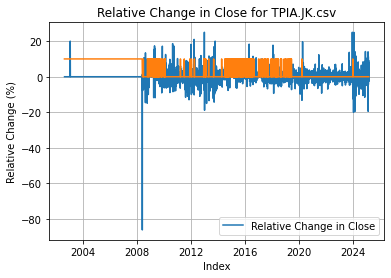

Total number of 0s in "Volume" for TPIA.JK.csv: 1960 in field ./input/fossil_100.
./input/fossil_100\TTE.csv
./input/fossil_100\TUPRS.IS.csv
./input/fossil_100\UGP.csv
./input/fossil_100\VLO.csv


<Figure size 720x360 with 0 Axes>

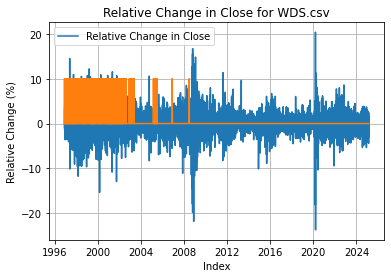

Total number of 0s in "Volume" for WDS.csv: 367 in field ./input/fossil_100.
./input/fossil_100\WMB.csv
./input/fossil_100\XOM.csv
./input/greencred_34\005930.KS.csv
./input/greencred_34\AAPL.csv
./input/greencred_34\ADBE.csv
./input/greencred_34\AMD.csv
./input/greencred_34\ASML.csv
./input/greencred_34\AVGO.csv
./input/greencred_34\CRM.csv
./input/greencred_34\CSCO.csv
./input/greencred_34\DHR.csv
./input/greencred_34\DIS.csv
./input/greencred_34\HD.csv
./input/greencred_34\IBM.csv
./input/greencred_34\INTC.csv
./input/greencred_34\INTU.csv
./input/greencred_34\LIN.csv
./input/greencred_34\MA.csv
./input/greencred_34\MC.PA.csv
./input/greencred_34\MSFT.csv
./input/greencred_34\NFLX.csv
./input/greencred_34\NKE.csv
./input/greencred_34\NVDA.csv
./input/greencred_34\NVS.csv
./input/greencred_34\ORCL.csv
./input/greencred_34\PFE.csv
./input/greencred_34\QCOM.csv
./input/greencred_34\RMS.PA.csv
./input/greencred_34\SAP.csv
./input/greencred_34\SPGI.csv
./input/greencred_34\TCS.NS.csv


<Figure size 720x360 with 0 Axes>

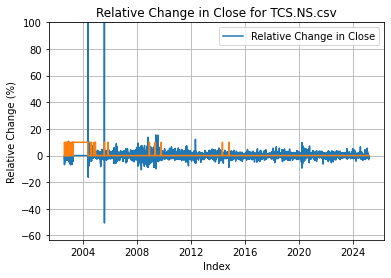

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/greencred_34.
./input/greencred_34\TMO.csv
./input/greencred_34\UNH.csv
./input/greencred_34\V.csv
./input/greencred_34\VZ.csv
./input/old_input\all_companies\005930.KS.csv
./input/old_input\all_companies\600519.SS.csv
./input/old_input\all_companies\AAPL.csv
./input/old_input\all_companies\ABT.csv
./input/old_input\all_companies\ADBE.csv
./input/old_input\all_companies\AMAT.csv
./input/old_input\all_companies\AMD.csv
./input/old_input\all_companies\AMGN.csv
./input/old_input\all_companies\AMZN.csv
./input/old_input\all_companies\ASML.csv
./input/old_input\all_companies\AVGO.csv
./input/old_input\all_companies\AXP.csv
./input/old_input\all_companies\AZN.csv
./input/old_input\all_companies\BA.csv
./input/old_input\all_companies\BAC.csv
./input/old_input\all_companies\BHP.csv
./input/old_input\all_companies\BKNG.csv
./input/old_input\all_companies\BRK-B.csv
./input/old_input\all_companies\CAT.csv
./input/old_input\all_co

<Figure size 720x360 with 0 Axes>

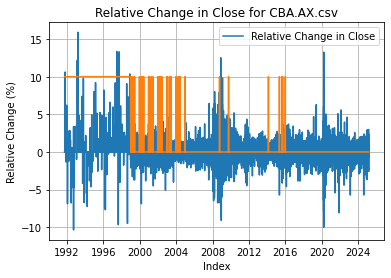

Total number of 0s in "Volume" for CBA.AX.csv: 1953 in field ./input/old_input\all_companies.
./input/old_input\all_companies\CDI.PA.csv
./input/old_input\all_companies\CMCSA.csv
./input/old_input\all_companies\COP.csv
./input/old_input\all_companies\COST.csv
./input/old_input\all_companies\CRM.csv
./input/old_input\all_companies\CSCO.csv
./input/old_input\all_companies\DHR.csv
./input/old_input\all_companies\DIS.csv
./input/old_input\all_companies\GOOG.csv
./input/old_input\all_companies\HD.csv
./input/old_input\all_companies\HDB.csv
./input/old_input\all_companies\HON.csv
./input/old_input\all_companies\IBM.csv
./input/old_input\all_companies\IDEXY.csv
./input/old_input\all_companies\INTC.csv
./input/old_input\all_companies\INTU.csv
./input/old_input\all_companies\ISRG.csv
./input/old_input\all_companies\JNJ.csv
./input/old_input\all_companies\JPM.csv
./input/old_input\all_companies\KO.csv
./input/old_input\all_companies\LIN.csv
./input/old_input\all_companies\LLY.csv
./input/old_inp

<Figure size 720x360 with 0 Axes>

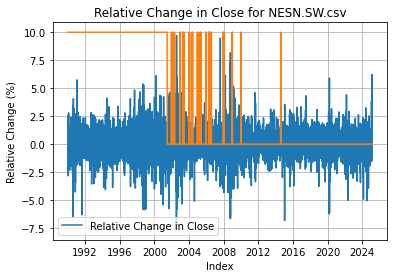

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\all_companies.
./input/old_input\all_companies\NFLX.csv
./input/old_input\all_companies\NKE.csv
./input/old_input\all_companies\NVDA.csv
./input/old_input\all_companies\NVO.csv
./input/old_input\all_companies\NVS.csv
./input/old_input\all_companies\OR.PA.csv
./input/old_input\all_companies\ORCL.csv
./input/old_input\all_companies\PEP.csv
./input/old_input\all_companies\PFE.csv
./input/old_input\all_companies\PG.csv
./input/old_input\all_companies\QCOM.csv
./input/old_input\all_companies\RMS.PA.csv
./input/old_input\all_companies\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

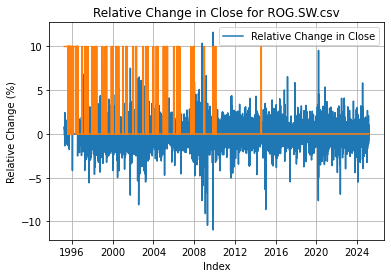

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\all_companies.
./input/old_input\all_companies\RTX.csv
./input/old_input\all_companies\RY.csv
./input/old_input\all_companies\SAP.csv
./input/old_input\all_companies\SCHW.csv
./input/old_input\all_companies\SONY.csv
./input/old_input\all_companies\SPGI.csv
./input/old_input\all_companies\T.csv
./input/old_input\all_companies\TCS.NS.csv


<Figure size 720x360 with 0 Axes>

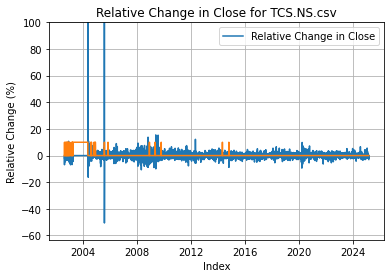

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/old_input\all_companies.
./input/old_input\all_companies\TM.csv
./input/old_input\all_companies\TMO.csv
./input/old_input\all_companies\TMUS.csv
./input/old_input\all_companies\TSM.csv
./input/old_input\all_companies\TTE.csv
./input/old_input\all_companies\TXN.csv
./input/old_input\all_companies\UL.csv
./input/old_input\all_companies\UNH.csv
./input/old_input\all_companies\UNP.csv
./input/old_input\all_companies\V.csv
./input/old_input\all_companies\VZ.csv
./input/old_input\all_companies\WFC.csv
./input/old_input\all_companies\WMT.csv


<Figure size 720x360 with 0 Axes>

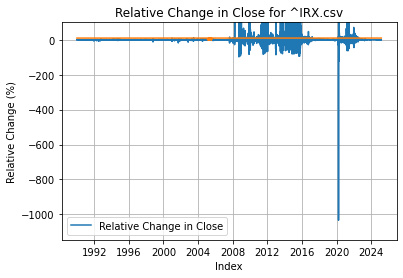

Total number of 0s in "Volume" for ^IRX.csv: 8776 in field ./input/old_input\Assorted.
./input/old_input\constsust_20\ABT.csv
./input/old_input\constsust_20\AMZN.csv
./input/old_input\constsust_20\AZN.csv
./input/old_input\constsust_20\BAC.csv
./input/old_input\constsust_20\BRK-B.csv
./input/old_input\constsust_20\COST.csv
./input/old_input\constsust_20\GOOG.csv
./input/old_input\constsust_20\JNJ.csv
./input/old_input\constsust_20\JPM.csv
./input/old_input\constsust_20\LLY.csv
./input/old_input\constsust_20\MCD.csv
./input/old_input\constsust_20\MRK.csv
./input/old_input\constsust_20\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

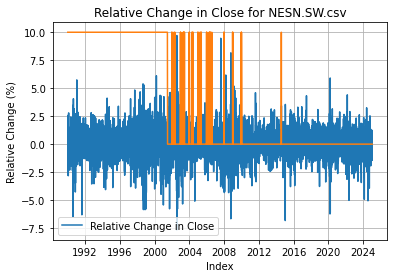

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\constsust_20.
./input/old_input\constsust_20\NVO.csv
./input/old_input\constsust_20\OR.PA.csv
./input/old_input\constsust_20\PEP.csv
./input/old_input\constsust_20\PG.csv
./input/old_input\constsust_20\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

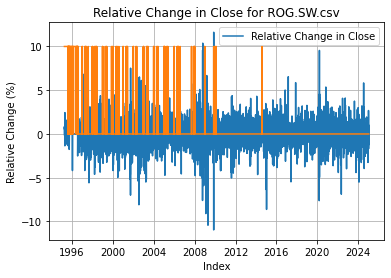

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\constsust_20.
./input/old_input\constsust_20\TM.csv
./input/old_input\constsust_20\WMT.csv
./input/old_input\constsust_32\ABT.csv
./input/old_input\constsust_32\AMGN.csv
./input/old_input\constsust_32\AMZN.csv
./input/old_input\constsust_32\AZN.csv
./input/old_input\constsust_32\BAC.csv
./input/old_input\constsust_32\BHP.csv
./input/old_input\constsust_32\BRK-B.csv
./input/old_input\constsust_32\CAT.csv
./input/old_input\constsust_32\CMCSA.csv
./input/old_input\constsust_32\COST.csv
./input/old_input\constsust_32\GOOG.csv
./input/old_input\constsust_32\HDB.csv
./input/old_input\constsust_32\JNJ.csv
./input/old_input\constsust_32\JPM.csv
./input/old_input\constsust_32\LLY.csv
./input/old_input\constsust_32\MCD.csv
./input/old_input\constsust_32\MRK.csv
./input/old_input\constsust_32\MS.csv
./input/old_input\constsust_32\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

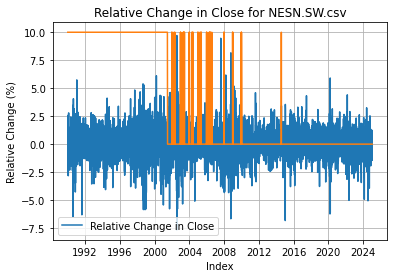

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\constsust_32.
./input/old_input\constsust_32\NVO.csv
./input/old_input\constsust_32\OR.PA.csv
./input/old_input\constsust_32\PEP.csv
./input/old_input\constsust_32\PG.csv
./input/old_input\constsust_32\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

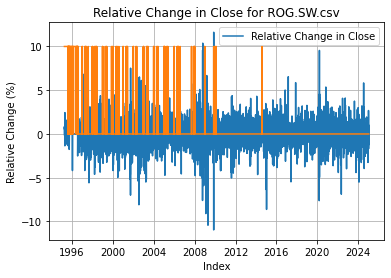

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\constsust_32.
./input/old_input\constsust_32\TM.csv
./input/old_input\constsust_32\TMUS.csv
./input/old_input\constsust_32\TTE.csv
./input/old_input\constsust_32\TXN.csv
./input/old_input\constsust_32\WMT.csv
./input/old_input\constsust_34\ABT.csv
./input/old_input\constsust_34\AMGN.csv
./input/old_input\constsust_34\AMZN.csv
./input/old_input\constsust_34\AZN.csv
./input/old_input\constsust_34\BAC.csv
./input/old_input\constsust_34\BHP.csv
./input/old_input\constsust_34\BRK-B.csv
./input/old_input\constsust_34\CAT.csv
./input/old_input\constsust_34\CMCSA.csv
./input/old_input\constsust_34\COST.csv
./input/old_input\constsust_34\GOOG.csv
./input/old_input\constsust_34\HDB.csv
./input/old_input\constsust_34\JNJ.csv
./input/old_input\constsust_34\JPM.csv
./input/old_input\constsust_34\LLY.csv
./input/old_input\constsust_34\MCD.csv
./input/old_input\constsust_34\MRK.csv
./input/old_input\constsust_34\MS.csv
./in

<Figure size 720x360 with 0 Axes>

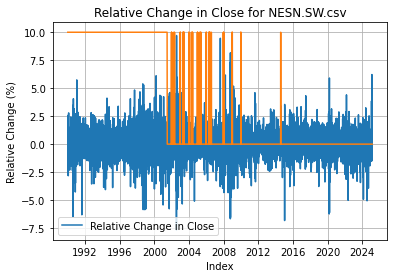

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\constsust_34.
./input/old_input\constsust_34\NVO.csv
./input/old_input\constsust_34\OR.PA.csv
./input/old_input\constsust_34\PEP.csv
./input/old_input\constsust_34\PG.csv
./input/old_input\constsust_34\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

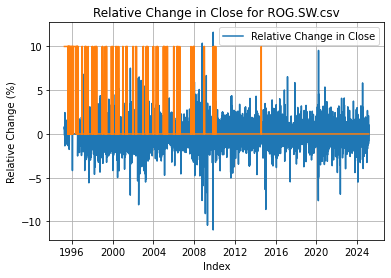

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\constsust_34.
./input/old_input\constsust_34\RY.csv
./input/old_input\constsust_34\TM.csv
./input/old_input\constsust_34\TMUS.csv
./input/old_input\constsust_34\TTE.csv
./input/old_input\constsust_34\TXN.csv
./input/old_input\constsust_34\WMT.csv
./input/old_input\fossil_100\0003.HK.csv
./input/old_input\fossil_100\010950.KS.csv
./input/old_input\fossil_100\0883.HK.csv
./input/old_input\fossil_100\096775.KS.csv
./input/old_input\fossil_100\1193.HK.csv
./input/old_input\fossil_100\1605.T.csv
./input/old_input\fossil_100\5019.T.csv
./input/old_input\fossil_100\600028.SS.csv
./input/old_input\fossil_100\6505.TW.csv
./input/old_input\fossil_100\9531.T.csv
./input/old_input\fossil_100\AKRBP.OL.csv
./input/old_input\fossil_100\ALD.AX.csv


<Figure size 720x360 with 0 Axes>

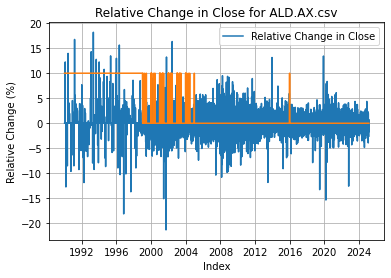

Total number of 0s in "Volume" for ALD.AX.csv: 2396 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\APA.csv
./input/old_input\fossil_100\BP.csv
./input/old_input\fossil_100\BRPT.JK.csv


<Figure size 720x360 with 0 Axes>

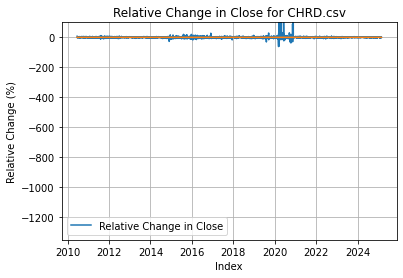

Total number of 0s in "Volume" for CHRD.csv: 0 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\CNA.L.csv
./input/old_input\fossil_100\CNQ.csv
./input/old_input\fossil_100\COP.csv
./input/old_input\fossil_100\CTRA.csv
./input/old_input\fossil_100\CVX.csv
./input/old_input\fossil_100\DINO.csv
./input/old_input\fossil_100\DUK.csv
./input/old_input\fossil_100\DVN.csv
./input/old_input\fossil_100\E.csv
./input/old_input\fossil_100\ENB.csv


<Figure size 720x360 with 0 Axes>

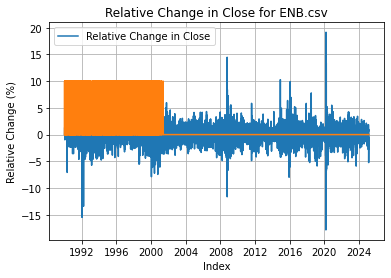

Total number of 0s in "Volume" for ENB.csv: 1237 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\ENLC.csv
./input/old_input\fossil_100\EOG.csv
./input/old_input\fossil_100\EPD.csv
./input/old_input\fossil_100\EQT.csv
./input/old_input\fossil_100\ET.csv
./input/old_input\fossil_100\FPE.F.csv


<Figure size 720x360 with 0 Axes>

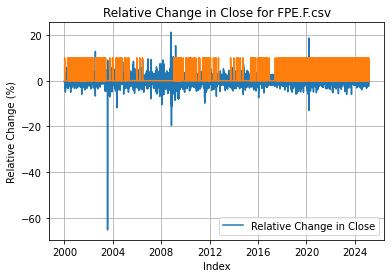

Total number of 0s in "Volume" for FPE.F.csv: 938 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\FTI.csv
./input/old_input\fossil_100\GAIL.NS.csv


<Figure size 720x360 with 0 Axes>

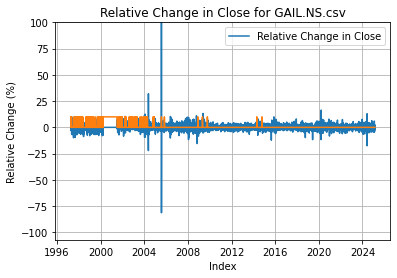

Total number of 0s in "Volume" for GAIL.NS.csv: 421 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\GZ5.F.csv


<Figure size 720x360 with 0 Axes>

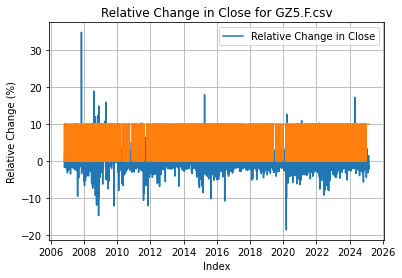

Total number of 0s in "Volume" for GZ5.F.csv: 3692 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\HAL.csv
./input/old_input\fossil_100\HES.csv
./input/old_input\fossil_100\HINDPETRO.NS.csv


<Figure size 720x360 with 0 Axes>

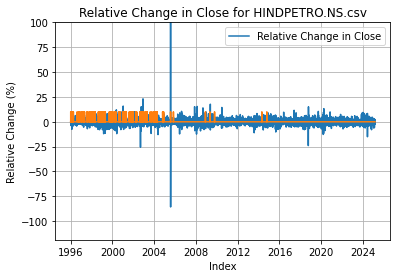

Total number of 0s in "Volume" for HINDPETRO.NS.csv: 120 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\IMO.csv
./input/old_input\fossil_100\IOC.NS.csv


<Figure size 720x360 with 0 Axes>

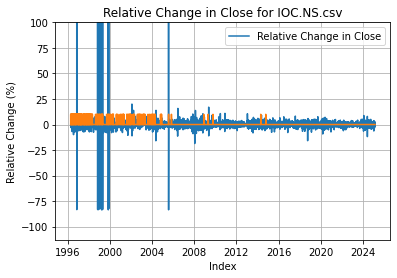

Total number of 0s in "Volume" for IOC.NS.csv: 293 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\KEY.TO.csv
./input/old_input\fossil_100\MOL.BD.csv
./input/old_input\fossil_100\NESTE.HE.csv
./input/old_input\fossil_100\NOV.csv
./input/old_input\fossil_100\OKE.csv
./input/old_input\fossil_100\OMV.F.csv


<Figure size 720x360 with 0 Axes>

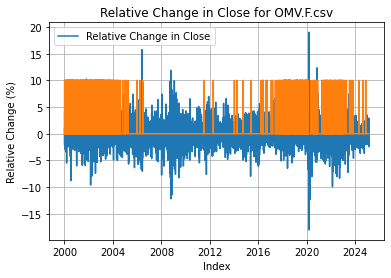

Total number of 0s in "Volume" for OMV.F.csv: 732 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\ONGC.NS.csv
./input/old_input\fossil_100\OVV.csv


<Figure size 720x360 with 0 Axes>

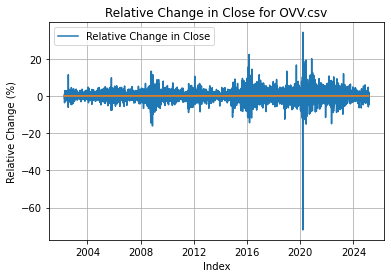

Total number of 0s in "Volume" for OVV.csv: 0 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\OXY.csv
./input/old_input\fossil_100\PAA.csv
./input/old_input\fossil_100\PBR.csv
./input/old_input\fossil_100\PKI.TO.csv


<Figure size 720x360 with 0 Axes>

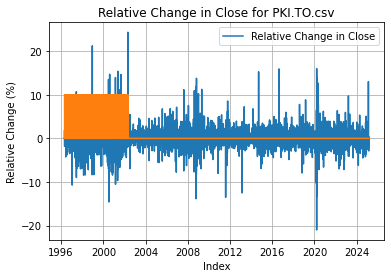

Total number of 0s in "Volume" for PKI.TO.csv: 498 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\PRIO3.SA.csv
./input/old_input\fossil_100\PTT-R.BK.csv


<Figure size 720x360 with 0 Axes>

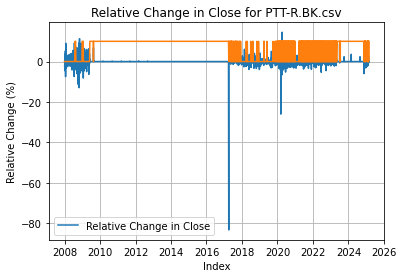

Total number of 0s in "Volume" for PTT-R.BK.csv: 1574 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\PTTEP.BK.csv


<Figure size 720x360 with 0 Axes>

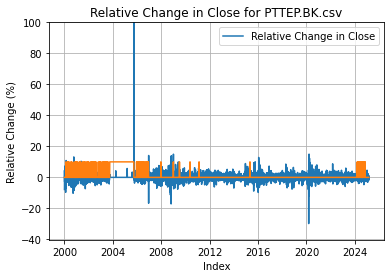

Total number of 0s in "Volume" for PTTEP.BK.csv: 649 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\RIG.csv
./input/old_input\fossil_100\RRC.csv


<Figure size 720x360 with 0 Axes>

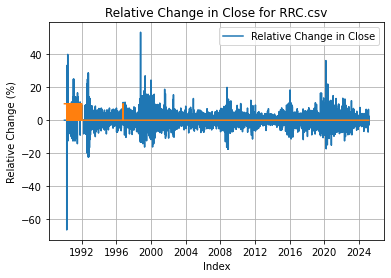

Total number of 0s in "Volume" for RRC.csv: 96 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\SHEL.csv
./input/old_input\fossil_100\SLB.csv
./input/old_input\fossil_100\SO.csv
./input/old_input\fossil_100\SRE.csv


<Figure size 720x360 with 0 Axes>

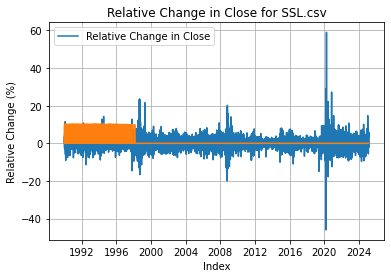

Total number of 0s in "Volume" for SSL.csv: 721 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\STO.AX.csv


<Figure size 720x360 with 0 Axes>

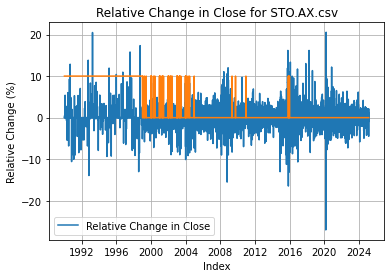

Total number of 0s in "Volume" for STO.AX.csv: 2404 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\SU.csv


<Figure size 720x360 with 0 Axes>

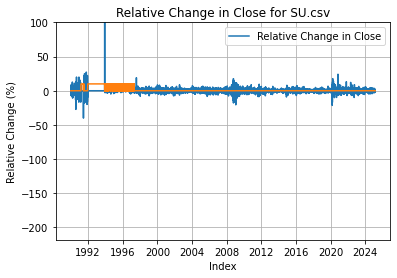

Total number of 0s in "Volume" for SU.csv: 1035 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\TPIA.JK.csv


<Figure size 720x360 with 0 Axes>

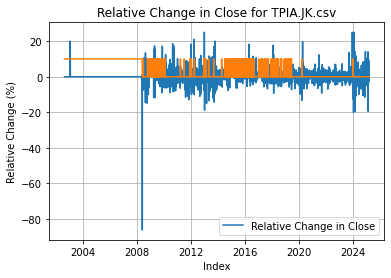

Total number of 0s in "Volume" for TPIA.JK.csv: 1960 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\TTE.csv
./input/old_input\fossil_100\TUPRS.IS.csv
./input/old_input\fossil_100\UGP.csv
./input/old_input\fossil_100\VLO.csv


<Figure size 720x360 with 0 Axes>

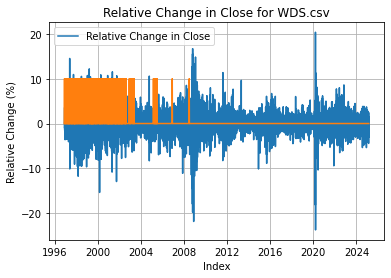

Total number of 0s in "Volume" for WDS.csv: 367 in field ./input/old_input\fossil_100.
./input/old_input\fossil_100\WMB.csv
./input/old_input\fossil_100\XOM.csv
./input/old_input\fossil_20\0883.HK.csv
./input/old_input\fossil_20\600028.SS.csv
./input/old_input\fossil_20\BP.csv
./input/old_input\fossil_20\CNQ.csv
./input/old_input\fossil_20\COP.csv
./input/old_input\fossil_20\CVX.csv
./input/old_input\fossil_20\DUK.csv
./input/old_input\fossil_20\E.csv
./input/old_input\fossil_20\ENB.csv


<Figure size 720x360 with 0 Axes>

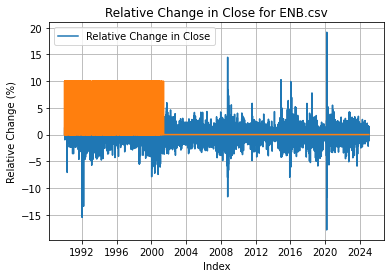

Total number of 0s in "Volume" for ENB.csv: 1237 in field ./input/old_input\fossil_20.
./input/old_input\fossil_20\EOG.csv
./input/old_input\fossil_20\EPD.csv
./input/old_input\fossil_20\OXY.csv
./input/old_input\fossil_20\PBR.csv
./input/old_input\fossil_20\SHEL.csv
./input/old_input\fossil_20\SLB.csv
./input/old_input\fossil_20\SO.csv
./input/old_input\fossil_20\TTE.csv
./input/old_input\fossil_20\XOM.csv
./input/old_input\fossil_32\0883.HK.csv
./input/old_input\fossil_32\600028.SS.csv
./input/old_input\fossil_32\BP.csv
./input/old_input\fossil_32\CNQ.csv
./input/old_input\fossil_32\COP.csv
./input/old_input\fossil_32\CVX.csv
./input/old_input\fossil_32\DUK.csv
./input/old_input\fossil_32\E.csv
./input/old_input\fossil_32\ENB.csv


<Figure size 720x360 with 0 Axes>

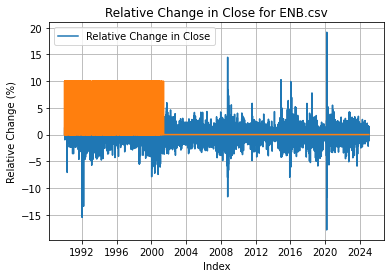

Total number of 0s in "Volume" for ENB.csv: 1237 in field ./input/old_input\fossil_32.
./input/old_input\fossil_32\EOG.csv
./input/old_input\fossil_32\EPD.csv
./input/old_input\fossil_32\ET.csv
./input/old_input\fossil_32\HES.csv
./input/old_input\fossil_32\OKE.csv
./input/old_input\fossil_32\OXY.csv
./input/old_input\fossil_32\PBR.csv
./input/old_input\fossil_32\SHEL.csv
./input/old_input\fossil_32\SLB.csv
./input/old_input\fossil_32\SO.csv
./input/old_input\fossil_32\SRE.csv
./input/old_input\fossil_32\TTE.csv
./input/old_input\fossil_32\VLO.csv


<Figure size 720x360 with 0 Axes>

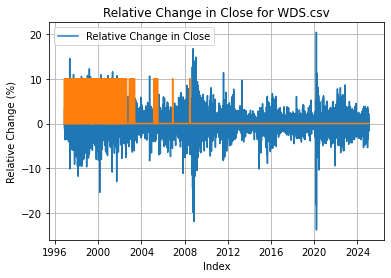

Total number of 0s in "Volume" for WDS.csv: 367 in field ./input/old_input\fossil_32.
./input/old_input\fossil_32\WMB.csv
./input/old_input\fossil_32\XOM.csv
./input/old_input\greencred_20\005930.KS.csv
./input/old_input\greencred_20\AAPL.csv
./input/old_input\greencred_20\ADBE.csv
./input/old_input\greencred_20\AMD.csv
./input/old_input\greencred_20\ASML.csv
./input/old_input\greencred_20\AVGO.csv
./input/old_input\greencred_20\CRM.csv
./input/old_input\greencred_20\HD.csv
./input/old_input\greencred_20\MA.csv
./input/old_input\greencred_20\MC.PA.csv
./input/old_input\greencred_20\MSFT.csv
./input/old_input\greencred_20\NFLX.csv
./input/old_input\greencred_20\NVDA.csv
./input/old_input\greencred_20\NVS.csv
./input/old_input\greencred_20\ORCL.csv
./input/old_input\greencred_20\RMS.PA.csv
./input/old_input\greencred_20\TMO.csv
./input/old_input\greencred_20\UNH.csv
./input/old_input\greencred_20\V.csv
./input/old_input\greencred_32\005930.KS.csv
./input/old_input\greencred_32\AAPL.csv
.

<Figure size 720x360 with 0 Axes>

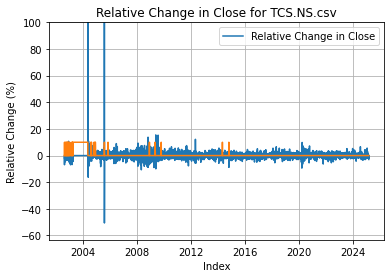

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/old_input\greencred_34.
./input/old_input\greencred_34\TMO.csv
./input/old_input\greencred_34\UNH.csv
./input/old_input\greencred_34\V.csv
./input/old_input\greencred_34\VZ.csv
./input/old_input\OldInputData\all_companies\005930.KS.csv
./input/old_input\OldInputData\all_companies\600519.SS.csv
./input/old_input\OldInputData\all_companies\AAPL.csv
./input/old_input\OldInputData\all_companies\ABT.csv
./input/old_input\OldInputData\all_companies\ADBE.csv
./input/old_input\OldInputData\all_companies\AMAT.csv
./input/old_input\OldInputData\all_companies\AMD.csv
./input/old_input\OldInputData\all_companies\AMGN.csv
./input/old_input\OldInputData\all_companies\AMZN.csv
./input/old_input\OldInputData\all_companies\ASML.csv
./input/old_input\OldInputData\all_companies\AVGO.csv
./input/old_input\OldInputData\all_companies\AXP.csv
./input/old_input\OldInputData\all_companies\AZN.csv
./input/old_input\OldInputData\all_companies\BA

<Figure size 720x360 with 0 Axes>

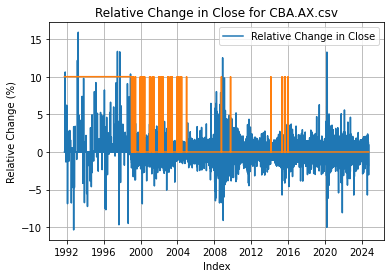

Total number of 0s in "Volume" for CBA.AX.csv: 1953 in field ./input/old_input\OldInputData\all_companies.
./input/old_input\OldInputData\all_companies\CDI.PA.csv
./input/old_input\OldInputData\all_companies\CMCSA.csv
./input/old_input\OldInputData\all_companies\COP.csv
./input/old_input\OldInputData\all_companies\COST.csv
./input/old_input\OldInputData\all_companies\CRM.csv
./input/old_input\OldInputData\all_companies\CSCO.csv
./input/old_input\OldInputData\all_companies\DHR.csv
./input/old_input\OldInputData\all_companies\DIS.csv
./input/old_input\OldInputData\all_companies\GOOG.csv
./input/old_input\OldInputData\all_companies\HD.csv
./input/old_input\OldInputData\all_companies\HDB.csv
./input/old_input\OldInputData\all_companies\HON.csv
./input/old_input\OldInputData\all_companies\IBM.csv
./input/old_input\OldInputData\all_companies\IDEXY.csv
./input/old_input\OldInputData\all_companies\INTC.csv
./input/old_input\OldInputData\all_companies\INTU.csv
./input/old_input\OldInputData\all

<Figure size 720x360 with 0 Axes>

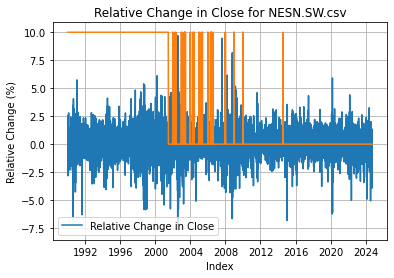

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\OldInputData\all_companies.
./input/old_input\OldInputData\all_companies\NFLX.csv
./input/old_input\OldInputData\all_companies\NKE.csv
./input/old_input\OldInputData\all_companies\NVDA.csv
./input/old_input\OldInputData\all_companies\NVO.csv
./input/old_input\OldInputData\all_companies\NVS.csv
./input/old_input\OldInputData\all_companies\OR.PA.csv
./input/old_input\OldInputData\all_companies\ORCL.csv
./input/old_input\OldInputData\all_companies\PEP.csv
./input/old_input\OldInputData\all_companies\PFE.csv
./input/old_input\OldInputData\all_companies\PG.csv
./input/old_input\OldInputData\all_companies\QCOM.csv
./input/old_input\OldInputData\all_companies\RMS.PA.csv
./input/old_input\OldInputData\all_companies\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

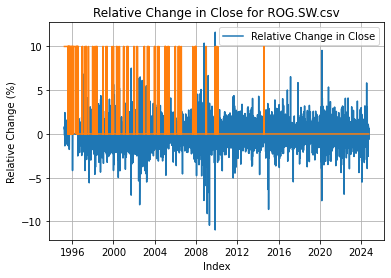

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\OldInputData\all_companies.
./input/old_input\OldInputData\all_companies\RTX.csv
./input/old_input\OldInputData\all_companies\RY.csv
./input/old_input\OldInputData\all_companies\SAP.csv
./input/old_input\OldInputData\all_companies\SCHW.csv
./input/old_input\OldInputData\all_companies\SONY.csv
./input/old_input\OldInputData\all_companies\SPGI.csv
./input/old_input\OldInputData\all_companies\T.csv
./input/old_input\OldInputData\all_companies\TCS.NS.csv
./input/old_input\OldInputData\all_companies\TM.csv
./input/old_input\OldInputData\all_companies\TMO.csv
./input/old_input\OldInputData\all_companies\TMUS.csv
./input/old_input\OldInputData\all_companies\TSM.csv
./input/old_input\OldInputData\all_companies\TTE.csv
./input/old_input\OldInputData\all_companies\TXN.csv
./input/old_input\OldInputData\all_companies\UL.csv
./input/old_input\OldInputData\all_companies\UNH.csv
./input/old_input\OldInputData\all_companies

<Figure size 720x360 with 0 Axes>

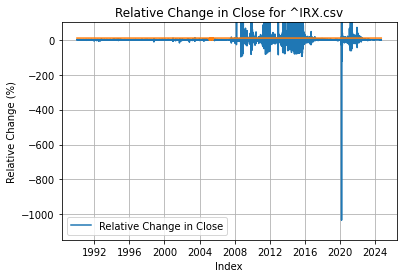

Total number of 0s in "Volume" for ^IRX.csv: 8677 in field ./input/old_input\OldInputData\Assorted.
./input/old_input\OldInputData\constsust_20\ABT.csv
./input/old_input\OldInputData\constsust_20\AMZN.csv
./input/old_input\OldInputData\constsust_20\AZN.csv
./input/old_input\OldInputData\constsust_20\BAC.csv
./input/old_input\OldInputData\constsust_20\BRK-B.csv
./input/old_input\OldInputData\constsust_20\COST.csv
./input/old_input\OldInputData\constsust_20\GOOG.csv
./input/old_input\OldInputData\constsust_20\JNJ.csv
./input/old_input\OldInputData\constsust_20\JPM.csv
./input/old_input\OldInputData\constsust_20\LLY.csv
./input/old_input\OldInputData\constsust_20\MCD.csv
./input/old_input\OldInputData\constsust_20\MRK.csv
./input/old_input\OldInputData\constsust_20\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

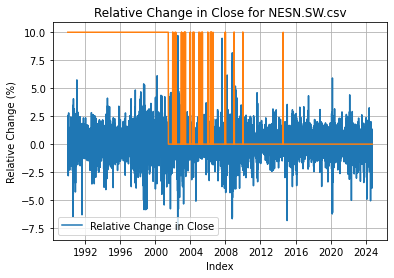

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\OldInputData\constsust_20.
./input/old_input\OldInputData\constsust_20\NVO.csv
./input/old_input\OldInputData\constsust_20\OR.PA.csv
./input/old_input\OldInputData\constsust_20\PEP.csv
./input/old_input\OldInputData\constsust_20\PG.csv
./input/old_input\OldInputData\constsust_20\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

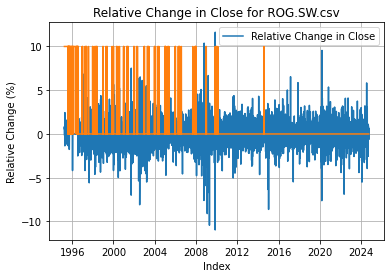

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\OldInputData\constsust_20.
./input/old_input\OldInputData\constsust_20\TM.csv
./input/old_input\OldInputData\constsust_20\WMT.csv
./input/old_input\OldInputData\constsust_32\ABT.csv
./input/old_input\OldInputData\constsust_32\AMGN.csv
./input/old_input\OldInputData\constsust_32\AMZN.csv
./input/old_input\OldInputData\constsust_32\AZN.csv
./input/old_input\OldInputData\constsust_32\BAC.csv
./input/old_input\OldInputData\constsust_32\BHP.csv
./input/old_input\OldInputData\constsust_32\BRK-B.csv
./input/old_input\OldInputData\constsust_32\CAT.csv
./input/old_input\OldInputData\constsust_32\CMCSA.csv
./input/old_input\OldInputData\constsust_32\COST.csv
./input/old_input\OldInputData\constsust_32\GOOG.csv
./input/old_input\OldInputData\constsust_32\HDB.csv
./input/old_input\OldInputData\constsust_32\JNJ.csv
./input/old_input\OldInputData\constsust_32\JPM.csv
./input/old_input\OldInputData\constsust_32\LLY.csv
./in

<Figure size 720x360 with 0 Axes>

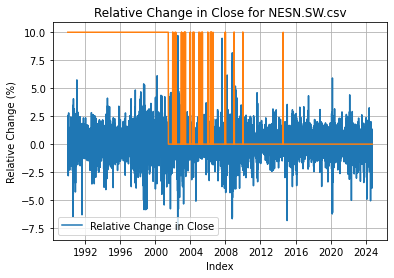

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\OldInputData\constsust_32.
./input/old_input\OldInputData\constsust_32\NVO.csv
./input/old_input\OldInputData\constsust_32\OR.PA.csv
./input/old_input\OldInputData\constsust_32\PEP.csv
./input/old_input\OldInputData\constsust_32\PG.csv
./input/old_input\OldInputData\constsust_32\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

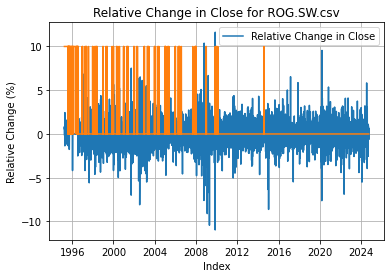

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\OldInputData\constsust_32.
./input/old_input\OldInputData\constsust_32\TM.csv
./input/old_input\OldInputData\constsust_32\TMUS.csv
./input/old_input\OldInputData\constsust_32\TTE.csv
./input/old_input\OldInputData\constsust_32\TXN.csv
./input/old_input\OldInputData\constsust_32\WMT.csv
./input/old_input\OldInputData\constsust_34\ABT.csv
./input/old_input\OldInputData\constsust_34\AMGN.csv
./input/old_input\OldInputData\constsust_34\AMZN.csv
./input/old_input\OldInputData\constsust_34\AZN.csv
./input/old_input\OldInputData\constsust_34\BAC.csv
./input/old_input\OldInputData\constsust_34\BHP.csv
./input/old_input\OldInputData\constsust_34\BRK-B.csv
./input/old_input\OldInputData\constsust_34\CAT.csv
./input/old_input\OldInputData\constsust_34\CMCSA.csv
./input/old_input\OldInputData\constsust_34\COST.csv
./input/old_input\OldInputData\constsust_34\GOOG.csv
./input/old_input\OldInputData\constsust_34\HDB.csv
./i

<Figure size 720x360 with 0 Axes>

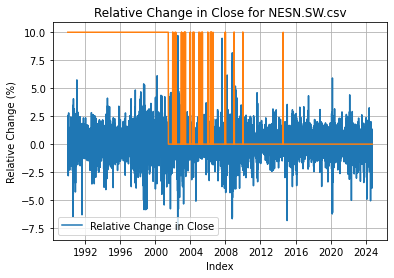

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\OldInputData\constsust_34.
./input/old_input\OldInputData\constsust_34\NVO.csv
./input/old_input\OldInputData\constsust_34\OR.PA.csv
./input/old_input\OldInputData\constsust_34\PEP.csv
./input/old_input\OldInputData\constsust_34\PG.csv
./input/old_input\OldInputData\constsust_34\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

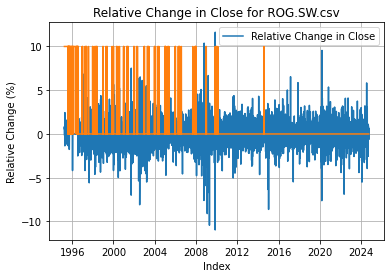

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\OldInputData\constsust_34.
./input/old_input\OldInputData\constsust_34\RY.csv
./input/old_input\OldInputData\constsust_34\TM.csv
./input/old_input\OldInputData\constsust_34\TMUS.csv
./input/old_input\OldInputData\constsust_34\TTE.csv
./input/old_input\OldInputData\constsust_34\TXN.csv
./input/old_input\OldInputData\constsust_34\WMT.csv
./input/old_input\OldInputData\fossil_100\0003.HK.csv
./input/old_input\OldInputData\fossil_100\010950.KS.csv
./input/old_input\OldInputData\fossil_100\0883.HK.csv
./input/old_input\OldInputData\fossil_100\096775.KS.csv
./input/old_input\OldInputData\fossil_100\1193.HK.csv
./input/old_input\OldInputData\fossil_100\1605.T.csv
./input/old_input\OldInputData\fossil_100\5019.T.csv
./input/old_input\OldInputData\fossil_100\600028.SS.csv
./input/old_input\OldInputData\fossil_100\6505.TW.csv
./input/old_input\OldInputData\fossil_100\9531.T.csv
./input/old_input\OldInputData\fossil_100

<Figure size 720x360 with 0 Axes>

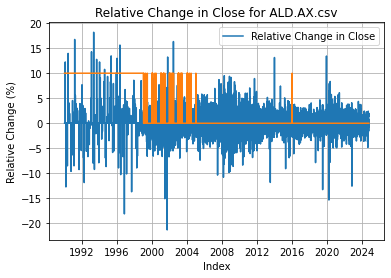

Total number of 0s in "Volume" for ALD.AX.csv: 2396 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\APA.csv
./input/old_input\OldInputData\fossil_100\BP.csv
./input/old_input\OldInputData\fossil_100\BRPT.JK.csv


<Figure size 720x360 with 0 Axes>

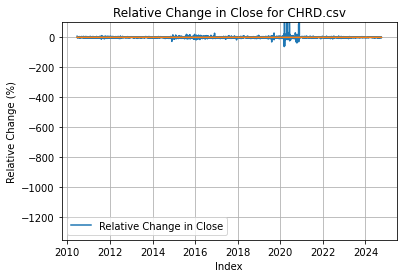

Total number of 0s in "Volume" for CHRD.csv: 0 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\CNA.L.csv
./input/old_input\OldInputData\fossil_100\CNQ.csv
./input/old_input\OldInputData\fossil_100\COP.csv
./input/old_input\OldInputData\fossil_100\CTRA.csv
./input/old_input\OldInputData\fossil_100\CVX.csv
./input/old_input\OldInputData\fossil_100\DINO.csv
./input/old_input\OldInputData\fossil_100\DUK.csv
./input/old_input\OldInputData\fossil_100\DVN.csv
./input/old_input\OldInputData\fossil_100\E.csv
./input/old_input\OldInputData\fossil_100\ENB.csv


<Figure size 720x360 with 0 Axes>

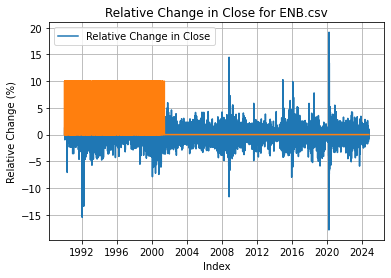

Total number of 0s in "Volume" for ENB.csv: 1237 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\ENLC.csv
./input/old_input\OldInputData\fossil_100\EOG.csv
./input/old_input\OldInputData\fossil_100\EPD.csv
./input/old_input\OldInputData\fossil_100\EQT.csv
./input/old_input\OldInputData\fossil_100\ET.csv
./input/old_input\OldInputData\fossil_100\FPE.F.csv


<Figure size 720x360 with 0 Axes>

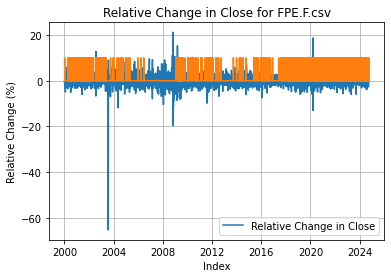

Total number of 0s in "Volume" for FPE.F.csv: 894 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\FTI.csv
./input/old_input\OldInputData\fossil_100\GAIL.NS.csv


<Figure size 720x360 with 0 Axes>

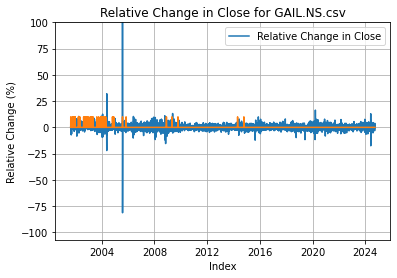

Total number of 0s in "Volume" for GAIL.NS.csv: 41 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\GZ5.F.csv


<Figure size 720x360 with 0 Axes>

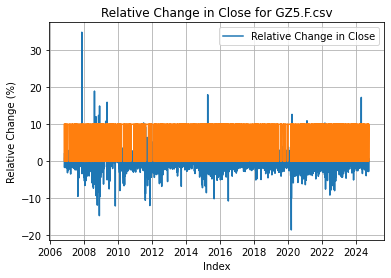

Total number of 0s in "Volume" for GZ5.F.csv: 3604 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\HAL.csv
./input/old_input\OldInputData\fossil_100\HES.csv
./input/old_input\OldInputData\fossil_100\HINDPETRO.NS.csv


<Figure size 720x360 with 0 Axes>

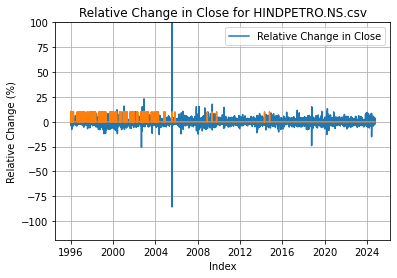

Total number of 0s in "Volume" for HINDPETRO.NS.csv: 120 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\IMO.csv
./input/old_input\OldInputData\fossil_100\IOC.NS.csv


<Figure size 720x360 with 0 Axes>

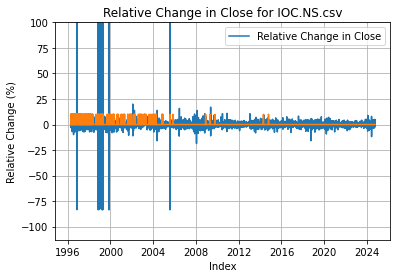

Total number of 0s in "Volume" for IOC.NS.csv: 293 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\KEY.TO.csv
./input/old_input\OldInputData\fossil_100\MOL.BD.csv
./input/old_input\OldInputData\fossil_100\MRO.csv
./input/old_input\OldInputData\fossil_100\NESTE.HE.csv
./input/old_input\OldInputData\fossil_100\NOV.csv
./input/old_input\OldInputData\fossil_100\OKE.csv
./input/old_input\OldInputData\fossil_100\OMV.F.csv


<Figure size 720x360 with 0 Axes>

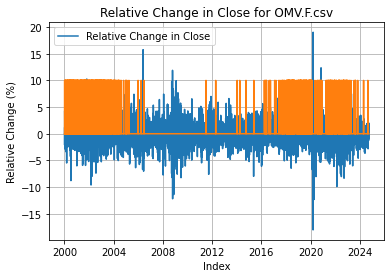

Total number of 0s in "Volume" for OMV.F.csv: 731 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\ONGC.NS.csv
./input/old_input\OldInputData\fossil_100\OVV.csv


<Figure size 720x360 with 0 Axes>

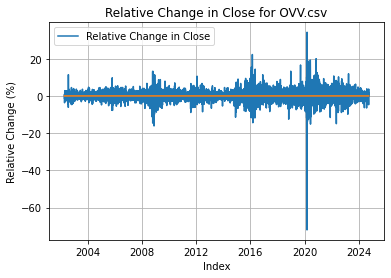

Total number of 0s in "Volume" for OVV.csv: 0 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\OXY.csv
./input/old_input\OldInputData\fossil_100\PAA.csv
./input/old_input\OldInputData\fossil_100\PBR.csv
./input/old_input\OldInputData\fossil_100\PKI.TO.csv


<Figure size 720x360 with 0 Axes>

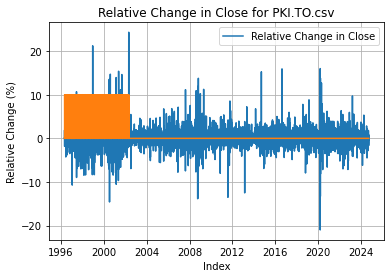

Total number of 0s in "Volume" for PKI.TO.csv: 498 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\PRIO3.SA.csv
./input/old_input\OldInputData\fossil_100\PTTEP.BK.csv


<Figure size 720x360 with 0 Axes>

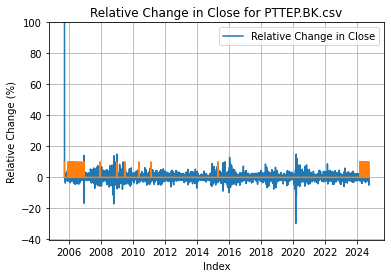

Total number of 0s in "Volume" for PTTEP.BK.csv: 75 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\RIG.csv
./input/old_input\OldInputData\fossil_100\RRC.csv
./input/old_input\OldInputData\fossil_100\SHEL.csv
./input/old_input\OldInputData\fossil_100\SLB.csv
./input/old_input\OldInputData\fossil_100\SO.csv
./input/old_input\OldInputData\fossil_100\SRE.csv


<Figure size 720x360 with 0 Axes>

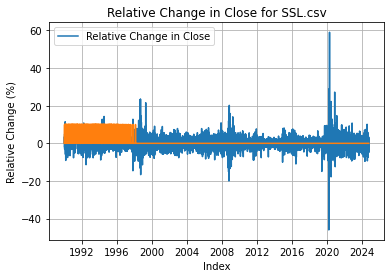

Total number of 0s in "Volume" for SSL.csv: 721 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\STO.AX.csv


<Figure size 720x360 with 0 Axes>

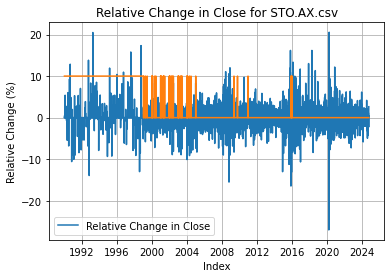

Total number of 0s in "Volume" for STO.AX.csv: 2404 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\SWN.csv
./input/old_input\OldInputData\fossil_100\TTE.csv
./input/old_input\OldInputData\fossil_100\TUPRS.IS.csv
./input/old_input\OldInputData\fossil_100\UGP.csv
./input/old_input\OldInputData\fossil_100\VLO.csv


<Figure size 720x360 with 0 Axes>

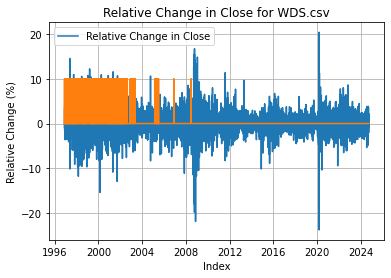

Total number of 0s in "Volume" for WDS.csv: 367 in field ./input/old_input\OldInputData\fossil_100.
./input/old_input\OldInputData\fossil_100\WMB.csv
./input/old_input\OldInputData\fossil_100\XOM.csv
./input/old_input\OldInputData\fossil_20\0883.HK.csv
./input/old_input\OldInputData\fossil_20\600028.SS.csv
./input/old_input\OldInputData\fossil_20\BP.csv
./input/old_input\OldInputData\fossil_20\CNQ.csv
./input/old_input\OldInputData\fossil_20\COP.csv
./input/old_input\OldInputData\fossil_20\CVX.csv
./input/old_input\OldInputData\fossil_20\DUK.csv
./input/old_input\OldInputData\fossil_20\E.csv
./input/old_input\OldInputData\fossil_20\ENB.csv


<Figure size 720x360 with 0 Axes>

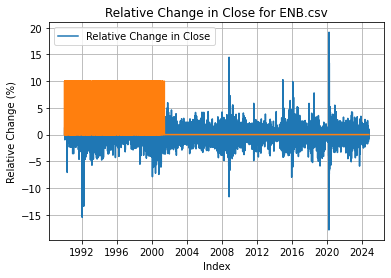

Total number of 0s in "Volume" for ENB.csv: 1237 in field ./input/old_input\OldInputData\fossil_20.
./input/old_input\OldInputData\fossil_20\EOG.csv
./input/old_input\OldInputData\fossil_20\EPD.csv
./input/old_input\OldInputData\fossil_20\OXY.csv
./input/old_input\OldInputData\fossil_20\PBR.csv
./input/old_input\OldInputData\fossil_20\SHEL.csv
./input/old_input\OldInputData\fossil_20\SLB.csv
./input/old_input\OldInputData\fossil_20\SO.csv
./input/old_input\OldInputData\fossil_20\TTE.csv
./input/old_input\OldInputData\fossil_20\XOM.csv
./input/old_input\OldInputData\fossil_32\0883.HK.csv
./input/old_input\OldInputData\fossil_32\600028.SS.csv
./input/old_input\OldInputData\fossil_32\BP.csv
./input/old_input\OldInputData\fossil_32\CNQ.csv
./input/old_input\OldInputData\fossil_32\COP.csv
./input/old_input\OldInputData\fossil_32\CVX.csv
./input/old_input\OldInputData\fossil_32\DUK.csv
./input/old_input\OldInputData\fossil_32\E.csv
./input/old_input\OldInputData\fossil_32\ENB.csv


<Figure size 720x360 with 0 Axes>

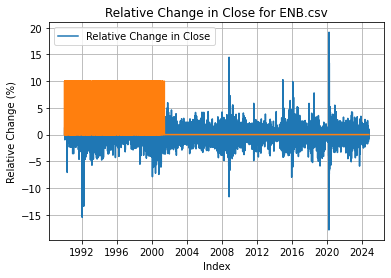

Total number of 0s in "Volume" for ENB.csv: 1237 in field ./input/old_input\OldInputData\fossil_32.
./input/old_input\OldInputData\fossil_32\EOG.csv
./input/old_input\OldInputData\fossil_32\EPD.csv
./input/old_input\OldInputData\fossil_32\ET.csv
./input/old_input\OldInputData\fossil_32\HES.csv
./input/old_input\OldInputData\fossil_32\OKE.csv
./input/old_input\OldInputData\fossil_32\OXY.csv
./input/old_input\OldInputData\fossil_32\PBR.csv
./input/old_input\OldInputData\fossil_32\SHEL.csv
./input/old_input\OldInputData\fossil_32\SLB.csv
./input/old_input\OldInputData\fossil_32\SO.csv
./input/old_input\OldInputData\fossil_32\SRE.csv
./input/old_input\OldInputData\fossil_32\TTE.csv
./input/old_input\OldInputData\fossil_32\VLO.csv


<Figure size 720x360 with 0 Axes>

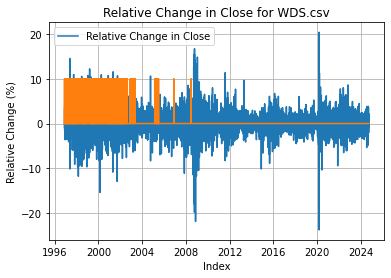

Total number of 0s in "Volume" for WDS.csv: 367 in field ./input/old_input\OldInputData\fossil_32.
./input/old_input\OldInputData\fossil_32\WMB.csv
./input/old_input\OldInputData\fossil_32\XOM.csv
./input/old_input\OldInputData\greencred_20\005930.KS.csv
./input/old_input\OldInputData\greencred_20\AAPL.csv
./input/old_input\OldInputData\greencred_20\ADBE.csv
./input/old_input\OldInputData\greencred_20\AMD.csv
./input/old_input\OldInputData\greencred_20\ASML.csv
./input/old_input\OldInputData\greencred_20\AVGO.csv
./input/old_input\OldInputData\greencred_20\CRM.csv
./input/old_input\OldInputData\greencred_20\HD.csv
./input/old_input\OldInputData\greencred_20\MA.csv
./input/old_input\OldInputData\greencred_20\MC.PA.csv
./input/old_input\OldInputData\greencred_20\MSFT.csv
./input/old_input\OldInputData\greencred_20\NFLX.csv
./input/old_input\OldInputData\greencred_20\NVDA.csv
./input/old_input\OldInputData\greencred_20\NVS.csv
./input/old_input\OldInputData\greencred_20\ORCL.csv
./input/o

<Figure size 720x360 with 0 Axes>

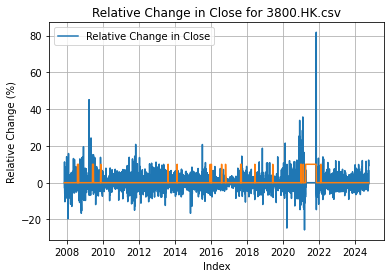

Total number of 0s in "Volume" for 3800.HK.csv: 176 in field ./input/old_input\OldInputData\renewable_20.
./input/old_input\OldInputData\renewable_20\BEP.csv
./input/old_input\OldInputData\renewable_20\BLX.TO.csv


<Figure size 720x360 with 0 Axes>

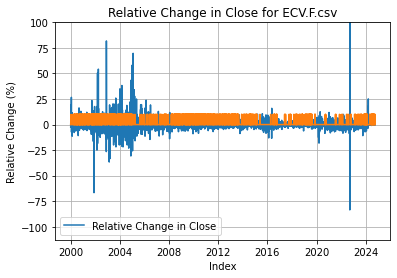

Total number of 0s in "Volume" for ECV.F.csv: 1529 in field ./input/old_input\OldInputData\renewable_20.
./input/old_input\OldInputData\renewable_20\EDPR.LS.csv
./input/old_input\OldInputData\renewable_20\NEE.csv
./input/old_input\OldInputData\renewable_20\PLUG.csv


<Figure size 720x360 with 0 Axes>

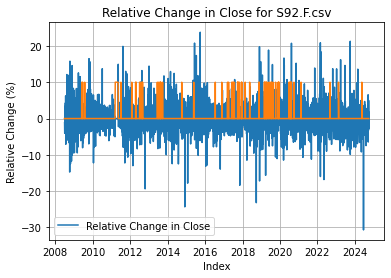

Total number of 0s in "Volume" for S92.F.csv: 110 in field ./input/old_input\OldInputData\renewable_20.
./input/old_input\OldInputData\renewable_20\SUZLON.NS.csv
./input/old_input\OldInputData\renewable_20\VWS.CO.csv
./input/old_input\OldInputData\renewable_all\009830.KS.csv
./input/old_input\OldInputData\renewable_all\1407.T.csv


<Figure size 720x360 with 0 Axes>

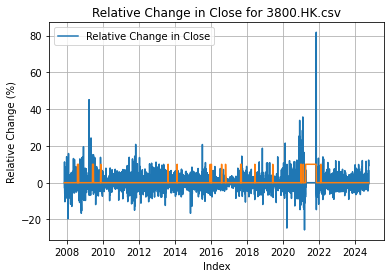

Total number of 0s in "Volume" for 3800.HK.csv: 176 in field ./input/old_input\OldInputData\renewable_all.
./input/old_input\OldInputData\renewable_all\AMTX.csv


<Figure size 720x360 with 0 Axes>

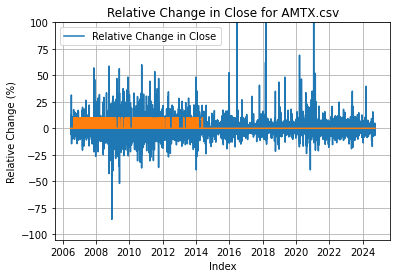

Total number of 0s in "Volume" for AMTX.csv: 300 in field ./input/old_input\OldInputData\renewable_all.
./input/old_input\OldInputData\renewable_all\BEP.csv
./input/old_input\OldInputData\renewable_all\BLX.TO.csv


<Figure size 720x360 with 0 Axes>

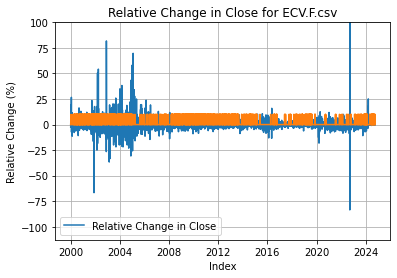

Total number of 0s in "Volume" for ECV.F.csv: 1529 in field ./input/old_input\OldInputData\renewable_all.
./input/old_input\OldInputData\renewable_all\EDPR.LS.csv
./input/old_input\OldInputData\renewable_all\ELLO.csv


<Figure size 720x360 with 0 Axes>

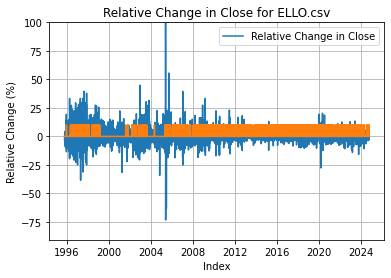

Total number of 0s in "Volume" for ELLO.csv: 1637 in field ./input/old_input\OldInputData\renewable_all.
./input/old_input\OldInputData\renewable_all\F3C.DE.csv


<Figure size 720x360 with 0 Axes>

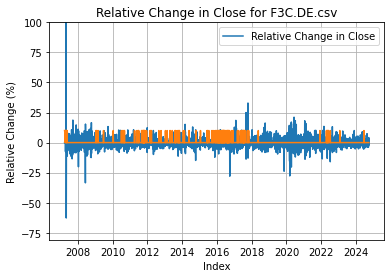

Total number of 0s in "Volume" for F3C.DE.csv: 204 in field ./input/old_input\OldInputData\renewable_all.
./input/old_input\OldInputData\renewable_all\NEE.csv
./input/old_input\OldInputData\renewable_all\NEL.OL.csv


<Figure size 720x360 with 0 Axes>

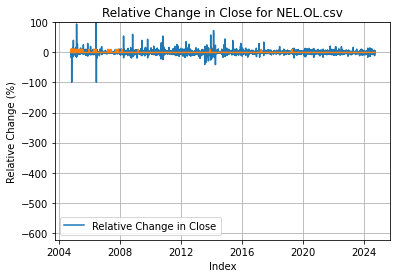

Total number of 0s in "Volume" for NEL.OL.csv: 68 in field ./input/old_input\OldInputData\renewable_all.
./input/old_input\OldInputData\renewable_all\PLUG.csv
./input/old_input\OldInputData\renewable_all\REX.csv


<Figure size 720x360 with 0 Axes>

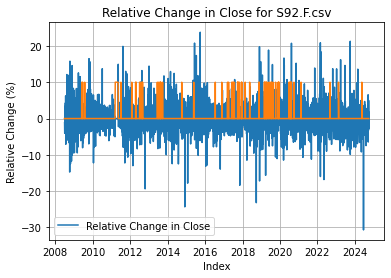

Total number of 0s in "Volume" for S92.F.csv: 110 in field ./input/old_input\OldInputData\renewable_all.
./input/old_input\OldInputData\renewable_all\SOL.csv
./input/old_input\OldInputData\renewable_all\SUZLON.NS.csv
./input/old_input\OldInputData\renewable_all\VWS.CO.csv
./input/old_input\renewable_20\009830.KS.csv


<Figure size 720x360 with 0 Axes>

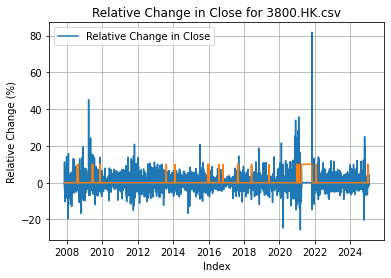

Total number of 0s in "Volume" for 3800.HK.csv: 178 in field ./input/old_input\renewable_20.
./input/old_input\renewable_20\BEP.csv
./input/old_input\renewable_20\BLX.TO.csv


<Figure size 720x360 with 0 Axes>

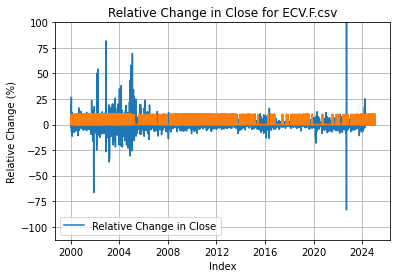

Total number of 0s in "Volume" for ECV.F.csv: 1561 in field ./input/old_input\renewable_20.
./input/old_input\renewable_20\EDPR.LS.csv
./input/old_input\renewable_20\NEE.csv
./input/old_input\renewable_20\PLUG.csv


<Figure size 720x360 with 0 Axes>

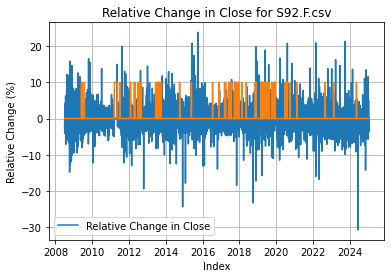

Total number of 0s in "Volume" for S92.F.csv: 110 in field ./input/old_input\renewable_20.
./input/old_input\renewable_20\SUZLON.NS.csv
./input/old_input\renewable_20\VWS.CO.csv
./input/old_input\renewable_all\009830.KS.csv
./input/old_input\renewable_all\1407.T.csv


<Figure size 720x360 with 0 Axes>

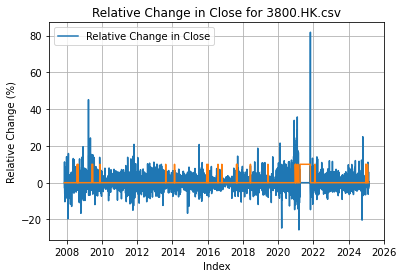

Total number of 0s in "Volume" for 3800.HK.csv: 179 in field ./input/old_input\renewable_all.


<Figure size 720x360 with 0 Axes>

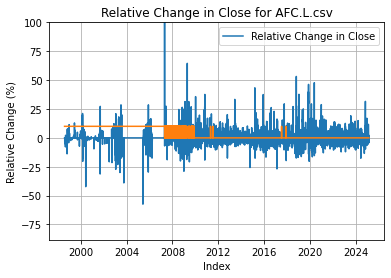

Total number of 0s in "Volume" for AFC.L.csv: 2575 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\AMTX.csv


<Figure size 720x360 with 0 Axes>

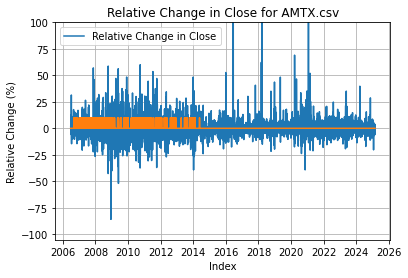

Total number of 0s in "Volume" for AMTX.csv: 300 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\BEP.csv
./input/old_input\renewable_all\BLX.TO.csv


<Figure size 720x360 with 0 Axes>

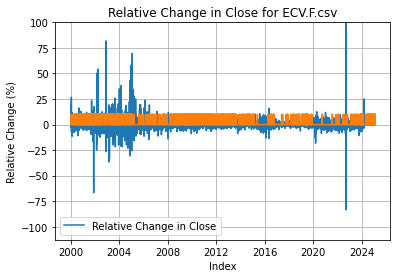

Total number of 0s in "Volume" for ECV.F.csv: 1565 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\EDPR.LS.csv


<Figure size 720x360 with 0 Axes>

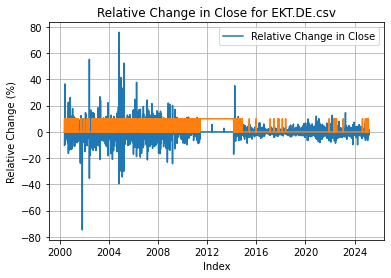

Total number of 0s in "Volume" for EKT.DE.csv: 1772 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\ELLO.csv


<Figure size 720x360 with 0 Axes>

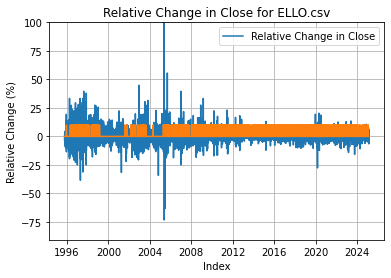

Total number of 0s in "Volume" for ELLO.csv: 1643 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\F3C.DE.csv


<Figure size 720x360 with 0 Axes>

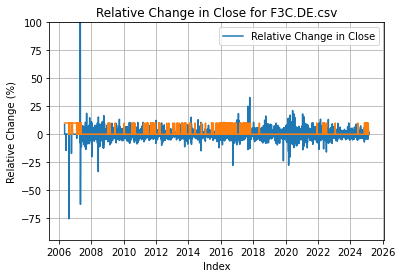

Total number of 0s in "Volume" for F3C.DE.csv: 430 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\NEE.csv
./input/old_input\renewable_all\NEL.OL.csv


<Figure size 720x360 with 0 Axes>

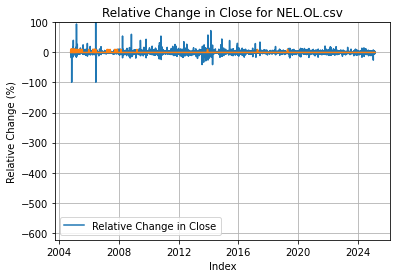

Total number of 0s in "Volume" for NEL.OL.csv: 68 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\PLUG.csv
./input/old_input\renewable_all\REX.csv


<Figure size 720x360 with 0 Axes>

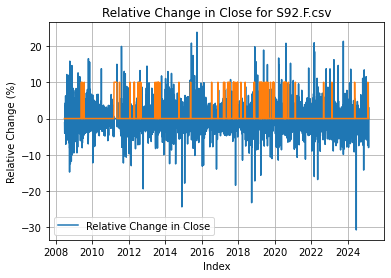

Total number of 0s in "Volume" for S92.F.csv: 111 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\SIRC.csv


<Figure size 720x360 with 0 Axes>

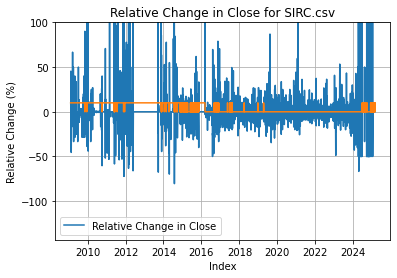

Total number of 0s in "Volume" for SIRC.csv: 1637 in field ./input/old_input\renewable_all.
./input/old_input\renewable_all\SOL.csv
./input/old_input\renewable_all\SUZLON.NS.csv
./input/old_input\renewable_all\VWS.CO.csv
./input/old_input\SandPESG_32\ABT.csv
./input/old_input\SandPESG_32\ADBE.csv
./input/old_input\SandPESG_32\ASML.csv
./input/old_input\SandPESG_32\AZN.csv
./input/old_input\SandPESG_32\CRM.csv
./input/old_input\SandPESG_32\CSCO.csv
./input/old_input\SandPESG_32\GOOG.csv
./input/old_input\SandPESG_32\INTC.csv
./input/old_input\SandPESG_32\LIN.csv
./input/old_input\SandPESG_32\LLY.csv
./input/old_input\SandPESG_32\MA.csv
./input/old_input\SandPESG_32\MC.PA.csv
./input/old_input\SandPESG_32\MRK.csv
./input/old_input\SandPESG_32\MSFT.csv
./input/old_input\SandPESG_32\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

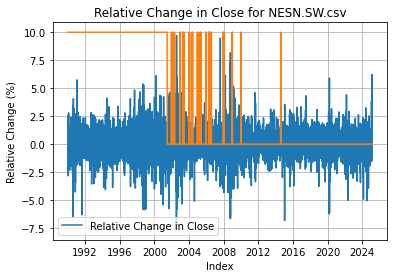

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\SandPESG_32.
./input/old_input\SandPESG_32\NVDA.csv
./input/old_input\SandPESG_32\OR.PA.csv
./input/old_input\SandPESG_32\ORCL.csv
./input/old_input\SandPESG_32\QCOM.csv
./input/old_input\SandPESG_32\RMS.PA.csv
./input/old_input\SandPESG_32\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

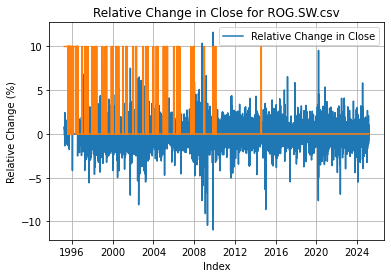

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\SandPESG_32.
./input/old_input\SandPESG_32\SAP.csv
./input/old_input\SandPESG_32\TCS.NS.csv


<Figure size 720x360 with 0 Axes>

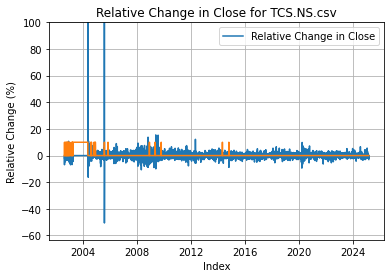

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/old_input\SandPESG_32.
./input/old_input\SandPESG_32\TM.csv
./input/old_input\SandPESG_32\TMO.csv
./input/old_input\SandPESG_32\TMUS.csv
./input/old_input\SandPESG_32\TTE.csv
./input/old_input\SandPESG_32\UNH.csv
./input/old_input\SandPESG_32\V.csv
./input/old_input\SandPESG_32\WMT.csv
./input/old_input\SandP_32\ABT.csv
./input/old_input\SandP_32\ADBE.csv
./input/old_input\SandP_32\AMD.csv
./input/old_input\SandP_32\ASML.csv
./input/old_input\SandP_32\AZN.csv
./input/old_input\SandP_32\BAC.csv
./input/old_input\SandP_32\CRM.csv
./input/old_input\SandP_32\CSCO.csv
./input/old_input\SandP_32\DHR.csv
./input/old_input\SandP_32\HDB.csv
./input/old_input\SandP_32\IBM.csv
./input/old_input\SandP_32\INTC.csv
./input/old_input\SandP_32\LIN.csv
./input/old_input\SandP_32\MA.csv
./input/old_input\SandP_32\MC.PA.csv
./input/old_input\SandP_32\MSFT.csv
./input/old_input\SandP_32\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

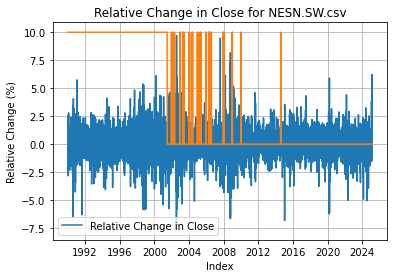

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/old_input\SandP_32.
./input/old_input\SandP_32\NVDA.csv
./input/old_input\SandP_32\NVS.csv
./input/old_input\SandP_32\OR.PA.csv
./input/old_input\SandP_32\QCOM.csv
./input/old_input\SandP_32\RMS.PA.csv
./input/old_input\SandP_32\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

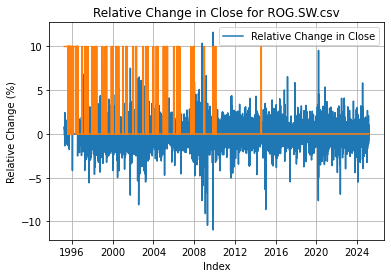

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/old_input\SandP_32.
./input/old_input\SandP_32\SAP.csv
./input/old_input\SandP_32\TCS.NS.csv


<Figure size 720x360 with 0 Axes>

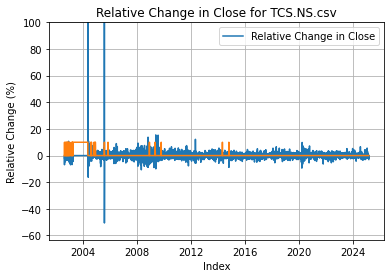

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/old_input\SandP_32.
./input/old_input\SandP_32\TMO.csv
./input/old_input\SandP_32\TTE.csv
./input/old_input\SandP_32\V.csv
./input/old_input\SandP_32\WMT.csv
./input/renewable_all\009830.KS.csv
./input/renewable_all\1407.T.csv


<Figure size 720x360 with 0 Axes>

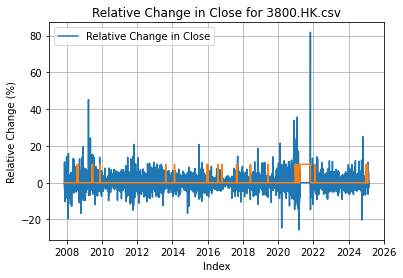

Total number of 0s in "Volume" for 3800.HK.csv: 179 in field ./input/renewable_all.


<Figure size 720x360 with 0 Axes>

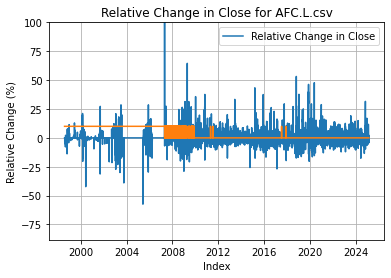

Total number of 0s in "Volume" for AFC.L.csv: 2575 in field ./input/renewable_all.
./input/renewable_all\AMTX.csv


<Figure size 720x360 with 0 Axes>

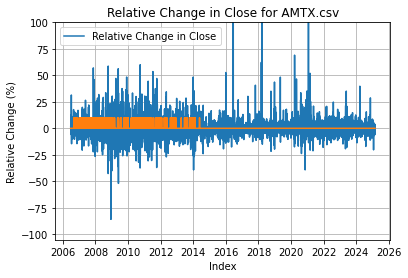

Total number of 0s in "Volume" for AMTX.csv: 300 in field ./input/renewable_all.
./input/renewable_all\BEP.csv
./input/renewable_all\BLX.TO.csv


<Figure size 720x360 with 0 Axes>

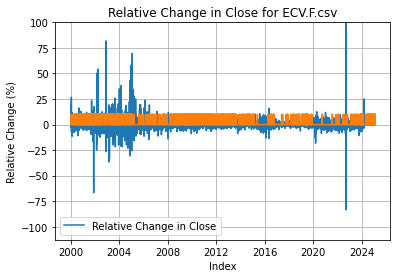

Total number of 0s in "Volume" for ECV.F.csv: 1565 in field ./input/renewable_all.
./input/renewable_all\EDPR.LS.csv


<Figure size 720x360 with 0 Axes>

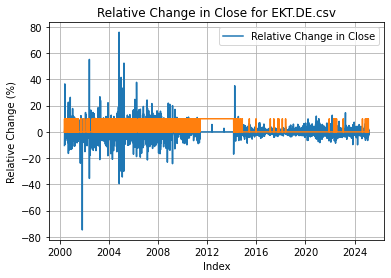

Total number of 0s in "Volume" for EKT.DE.csv: 1772 in field ./input/renewable_all.
./input/renewable_all\ELLO.csv


<Figure size 720x360 with 0 Axes>

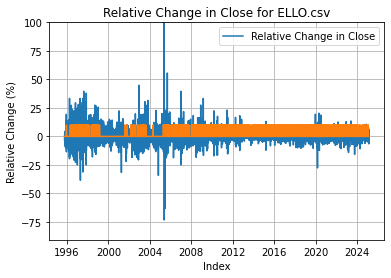

Total number of 0s in "Volume" for ELLO.csv: 1643 in field ./input/renewable_all.
./input/renewable_all\F3C.DE.csv


<Figure size 720x360 with 0 Axes>

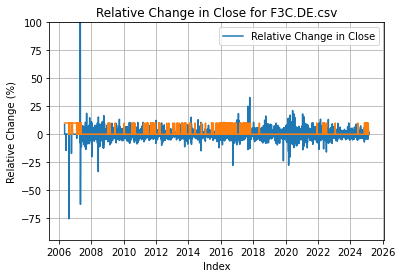

Total number of 0s in "Volume" for F3C.DE.csv: 430 in field ./input/renewable_all.
./input/renewable_all\NEE.csv
./input/renewable_all\NEL.OL.csv


<Figure size 720x360 with 0 Axes>

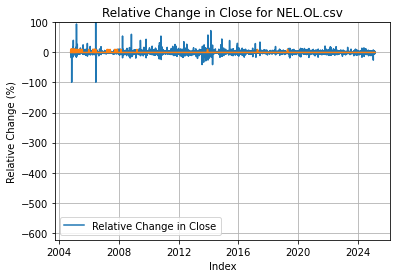

Total number of 0s in "Volume" for NEL.OL.csv: 68 in field ./input/renewable_all.
./input/renewable_all\PLUG.csv
./input/renewable_all\REX.csv


<Figure size 720x360 with 0 Axes>

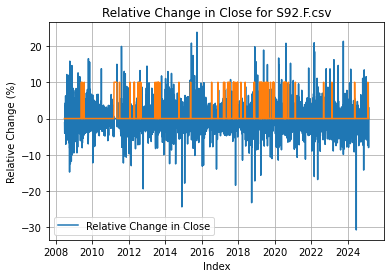

Total number of 0s in "Volume" for S92.F.csv: 111 in field ./input/renewable_all.
./input/renewable_all\SIRC.csv


<Figure size 720x360 with 0 Axes>

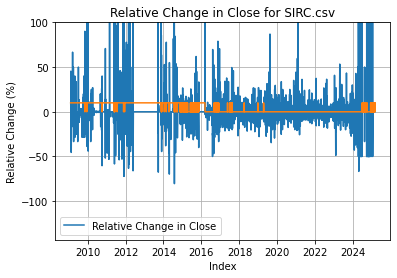

Total number of 0s in "Volume" for SIRC.csv: 1637 in field ./input/renewable_all.
./input/renewable_all\SOL.csv
./input/renewable_all\SUZLON.NS.csv
./input/renewable_all\VWS.CO.csv
./input/SandPESG_32\ABT.csv
./input/SandPESG_32\ADBE.csv
./input/SandPESG_32\ASML.csv
./input/SandPESG_32\AZN.csv
./input/SandPESG_32\CRM.csv
./input/SandPESG_32\CSCO.csv
./input/SandPESG_32\GOOG.csv
./input/SandPESG_32\INTC.csv
./input/SandPESG_32\LIN.csv
./input/SandPESG_32\LLY.csv
./input/SandPESG_32\MA.csv
./input/SandPESG_32\MC.PA.csv
./input/SandPESG_32\MRK.csv
./input/SandPESG_32\MSFT.csv
./input/SandPESG_32\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

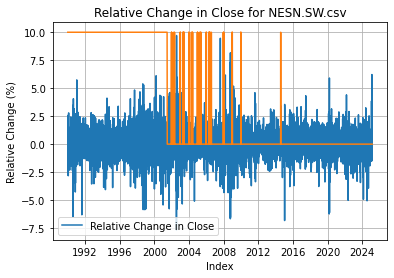

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/SandPESG_32.
./input/SandPESG_32\NVDA.csv
./input/SandPESG_32\OR.PA.csv
./input/SandPESG_32\ORCL.csv
./input/SandPESG_32\QCOM.csv
./input/SandPESG_32\RMS.PA.csv
./input/SandPESG_32\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

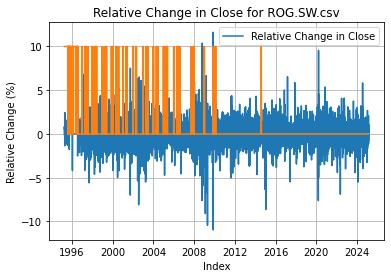

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/SandPESG_32.
./input/SandPESG_32\SAP.csv
./input/SandPESG_32\TCS.NS.csv


<Figure size 720x360 with 0 Axes>

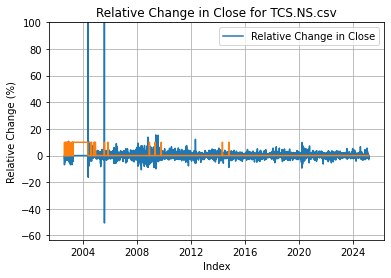

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/SandPESG_32.
./input/SandPESG_32\TM.csv
./input/SandPESG_32\TMO.csv
./input/SandPESG_32\TMUS.csv
./input/SandPESG_32\TTE.csv
./input/SandPESG_32\UNH.csv
./input/SandPESG_32\V.csv
./input/SandPESG_32\WMT.csv
./input/SandP_32\ABT.csv
./input/SandP_32\ADBE.csv
./input/SandP_32\AMD.csv
./input/SandP_32\ASML.csv
./input/SandP_32\AZN.csv
./input/SandP_32\BAC.csv
./input/SandP_32\CRM.csv
./input/SandP_32\CSCO.csv
./input/SandP_32\DHR.csv
./input/SandP_32\HDB.csv
./input/SandP_32\IBM.csv
./input/SandP_32\INTC.csv
./input/SandP_32\LIN.csv
./input/SandP_32\MA.csv
./input/SandP_32\MC.PA.csv
./input/SandP_32\MSFT.csv
./input/SandP_32\NESN.SW.csv


<Figure size 720x360 with 0 Axes>

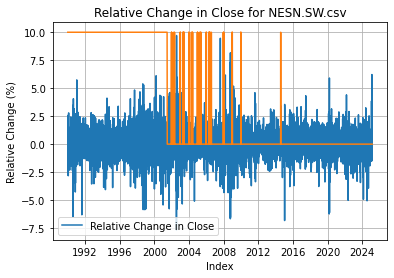

Total number of 0s in "Volume" for NESN.SW.csv: 3043 in field ./input/SandP_32.
./input/SandP_32\NVDA.csv
./input/SandP_32\NVS.csv
./input/SandP_32\OR.PA.csv
./input/SandP_32\QCOM.csv
./input/SandP_32\RMS.PA.csv
./input/SandP_32\ROG.SW.csv


<Figure size 720x360 with 0 Axes>

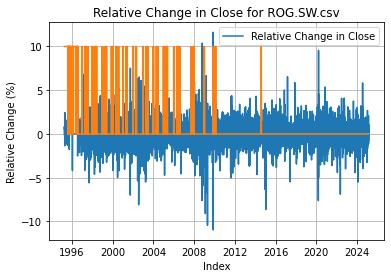

Total number of 0s in "Volume" for ROG.SW.csv: 430 in field ./input/SandP_32.
./input/SandP_32\SAP.csv
./input/SandP_32\TCS.NS.csv


<Figure size 720x360 with 0 Axes>

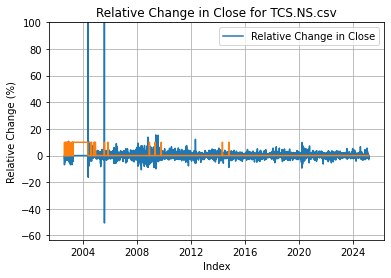

Total number of 0s in "Volume" for TCS.NS.csv: 310 in field ./input/SandP_32.
./input/SandP_32\TMO.csv
./input/SandP_32\TTE.csv
./input/SandP_32\V.csv
./input/SandP_32\WMT.csv


In [29]:
questionable_files = {}
delete_files = []
stocksplits = []
chain_limit = 40 # The maximum number of consecutive 0s to allow before we cut the data. 

for subdir, dirs, files in os.walk("./input/"):
    for file in files:
        if file.endswith('.csv'):  # Process only CSV files
            file_path = os.path.join(subdir, file)
            
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(file_path, parse_dates=[0])
            
            # Check if the required columns are in the DataFrame
            if 'Close' in df.columns and 'Volume' in df.columns:
                
                # Calculate the relative change in 'Close' column
                df['Close_Change'] = df['Close'].pct_change() * 100
                df["CumNoVol"] = (df['Volume'] == 0).cumsum()
                df["NoVolNoChange"] = ((df['Close_Change']==0) * (df['Volume'] == 0))
                df["NoVolNoChangeChain"] = count_true_chains(df["NoVolNoChange"])
                if (df["Stock Splits"] != 0).any():
                    print(file_path)
                    stocksplits.append(file_path)
                if (df['Close_Change'].max() > 150) | (df['Close_Change'].min() < -70) | (
                    df["CumNoVol"].max() > 300) | (df["NoVolNoChangeChain"].max() > 40):
                    # Plot the relative change
                    plt.figure(figsize=(10, 5))
                    fig, ax = plt.subplots()
                    ax.plot(df['Date'], df['Close_Change'], label='Relative Change in Close')
                    ax.plot(df['Date'], (df['Volume'] == 0)*10)
                    plt.title(f'Relative Change in Close for {file}')
                    plt.xlabel('Index')
                    plt.ylabel('Relative Change (%)')
                    plt.legend()
                    plt.grid(True)
                    y_min, y_max = ax.get_ylim()

                    # Restrict the y-axis upper limit to less than 100 if it's greater than 100
                    if y_max > 100:
                        ax.set_ylim(top=100)
                    plt.show()

                    # Count the number of zeros in the 'Volume' column
                    print(f'Total number of 0s in "Volume" for {file}: {df.loc[len(df)-1, "CumNoVol"]} in field {subdir}.')
                    latest_chain_date = find_latest_row_with_chain_above(df, "NoVolNoChangeChain", chain_limit)
                    if latest_chain_date:
                        # Add the file to the list of questionable/deletable files
                        if ((df['Close_Change'].max() > 100) | (df['Close_Change'].min() < -50)):
                            if (latest_chain_date > start_date_needed):
                                delete_files.append(file_path)
                            else:
                                questionable_files[file_path] = latest_chain_date

In [30]:
questionable_files

{'./input/all_companies\\TCS.NS.csv': Timestamp('2004-05-05 00:00:00'),
 './input/fossil_100\\GAIL.NS.csv': Timestamp('2001-06-29 00:00:00'),
 './input/fossil_100\\PTTEP.BK.csv': Timestamp('2005-08-09 00:00:00'),
 './input/fossil_100\\RRC.csv': Timestamp('1990-04-09 00:00:00'),
 './input/fossil_100\\SU.csv': Timestamp('1993-11-30 00:00:00'),
 './input/fossil_100\\TPIA.JK.csv': Timestamp('2008-05-23 00:00:00'),
 './input/greencred_34\\TCS.NS.csv': Timestamp('2004-05-05 00:00:00'),
 './input/old_input\\all_companies\\TCS.NS.csv': Timestamp('2004-05-05 00:00:00'),
 './input/old_input\\fossil_100\\GAIL.NS.csv': Timestamp('2001-06-29 00:00:00'),
 './input/old_input\\fossil_100\\PTTEP.BK.csv': Timestamp('2005-08-09 00:00:00'),
 './input/old_input\\fossil_100\\RRC.csv': Timestamp('1990-04-09 00:00:00'),
 './input/old_input\\fossil_100\\SU.csv': Timestamp('1993-11-30 00:00:00'),
 './input/old_input\\fossil_100\\TPIA.JK.csv': Timestamp('2008-05-23 00:00:00'),
 './input/old_input\\greencred_34\\

In [31]:
delete_files

['./input/fossil_100\\PTT-R.BK.csv',
 './input/old_input\\fossil_100\\PTT-R.BK.csv',
 './input/old_input\\renewable_all\\EKT.DE.csv',
 './input/old_input\\renewable_all\\SIRC.csv',
 './input/renewable_all\\EKT.DE.csv',
 './input/renewable_all\\SIRC.csv']

In [32]:
# Unsalvagable data:
for file_path in delete_files:
    try:
        if os.path.exists(file_path):
            os.remove(file_path)
            print(f"Deleted: {file_path}")
        else:
            print(f"File not found: {file_path}")
    except Exception as e:
        print(f"Error deleting {file_path}: {e}")

Deleted: ./input/fossil_100\PTT-R.BK.csv
Deleted: ./input/old_input\fossil_100\PTT-R.BK.csv
Deleted: ./input/old_input\renewable_all\EKT.DE.csv
Deleted: ./input/old_input\renewable_all\SIRC.csv
Deleted: ./input/renewable_all\EKT.DE.csv
Deleted: ./input/renewable_all\SIRC.csv


In [33]:
def filter_csv_by_date(file_path, date_column, end_date, fringe):
    """
    Load a CSV file, filter out rows with dates up until and including a given cutoff date, and overwrite the file.
    
    Parameters:
    file_path (str): The path to the CSV file.
    date_column (str): The name of the column containing date values.
    end_date (str): The end date in 'YYYY-MM-DD' format where a curious behaviour stops. (Inclusive)
    fringe (int): the number of days after end_date to remove too.
    
    Returns:
    None
    """
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path, parse_dates=[date_column])

    # Filter rows to only keep dates after the cutoff date
    filtered_df = df[(df[date_column] >= end_date + timedelta(days=fringe))]

    # Overwrite the original file with the filtered data
    filtered_df.to_csv(file_path, index=False)

In [34]:
endfringe = 50
for file, enddate in questionable_files.items():
    print(file)
    filter_csv_by_date(file, "Date", enddate, endfringe)

./input/all_companies\TCS.NS.csv
./input/fossil_100\GAIL.NS.csv
./input/fossil_100\PTTEP.BK.csv
./input/fossil_100\RRC.csv
./input/fossil_100\SU.csv
./input/fossil_100\TPIA.JK.csv
./input/greencred_34\TCS.NS.csv
./input/old_input\all_companies\TCS.NS.csv
./input/old_input\fossil_100\GAIL.NS.csv
./input/old_input\fossil_100\PTTEP.BK.csv
./input/old_input\fossil_100\RRC.csv
./input/old_input\fossil_100\SU.csv
./input/old_input\fossil_100\TPIA.JK.csv
./input/old_input\greencred_34\TCS.NS.csv
./input/old_input\renewable_all\AFC.L.csv
./input/old_input\renewable_all\F3C.DE.csv
./input/old_input\SandPESG_32\TCS.NS.csv
./input/old_input\SandP_32\TCS.NS.csv
./input/renewable_all\AFC.L.csv
./input/renewable_all\F3C.DE.csv
./input/SandPESG_32\TCS.NS.csv
./input/SandP_32\TCS.NS.csv


# Copy some files into smaller folders for robustness analysis

In [35]:
get_smaller_folders = {
    "constsust_34": ["constsust_20", "constsust_32"], "greencred_34": ["greencred_20", "greencred_32"],
    "fossil_100": ["fossil_20", "fossil_32"], "renewable_all": ["renewable_20"]
}

In [36]:
# Files are downloaded in order of size, so we want the earliest files for the subgroup analysis
def copy_oldest_files(src_folder, dst_folder, n):
    # Convert to Path objects for better path handling
    src_folder = Path(src_folder)
    dst_folder = Path(dst_folder)
    
    # Ensure destination folder exists
    dst_folder.mkdir(parents=True, exist_ok=True)
    
    # Get a list of all CSV files in the source directory
    all_files = [f for f in src_folder.iterdir() if f.is_file() and f.suffix == '.csv']
    
    # Raise an error if there are fewer than n CSV files
    if len(all_files) < n:
        raise ValueError(f"Not enough CSV files in the source directory. Found {len(all_files)}, but need {n}.")
    
    # Sort files by creation/modification time (depending on OS)
    all_files.sort(key=lambda f: f.stat().st_mtime)  # st_mtime is the last modification time

    # Select the N oldest files
    oldest_files = all_files[:n]
    
    # Copy the N oldest CSV files to the destination folder
    for file in oldest_files:
        shutil.copy(file, dst_folder)
def delete_youngest_files(directory, n):
    # Convert to a Path object for easier path handling
    directory = Path(directory)
    
    # Get a list of all files in the directory
    all_files = [f for f in directory.iterdir() if f.is_file()]
    
    # Sort files by creation/modification time (newest first)
    all_files.sort(key=lambda f: f.stat().st_mtime, reverse=True)
    
    # Select the youngest files in excess of the required number
    youngest_files = all_files[:(len(all_files) - n)]
    
    # Delete the N youngest files
    for file in youngest_files:
        print(f"Deleting {file}")  # For tracking purposes
        file.unlink()  # This deletes the file

In [37]:
baseFolder = "./input/"
for oldFolder, newFolders in get_smaller_folders.items():
    for newFolder in newFolders:
        nFiles = int(newFolder.split("_")[1])
        copy_oldest_files(baseFolder + oldFolder, baseFolder + newFolder, nFiles)

In [38]:
# Delete any excess files downloaded
delete_youngest_files(baseFolder + "fossil_100", 100)
# Downloads are done!

In [43]:
# Establish the differences between the SandP ESG metrics
set(dir_and_files["SandPESG_32"]) - set(dir_and_files["SandP_32"])

{'GOOG', 'LLY', 'MRK', 'ORCL', 'TM', 'TMUS', 'UNH'}

In [44]:
 set(dir_and_files["SandP_32"]) - set(dir_and_files["SandPESG_32"])

{'AMD', 'BAC', 'DHR', 'HDB', 'IBM', 'NVS', 'PM'}